In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import random
import scipy.stats as stats

In [2]:
# load data: https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction?select=Medicalpremium.csv
# data set to predict insurance premium based on demographic/health/other factors.
data = pd.read_csv("../AB/Medicalpremium.csv")
print(data.shape)
data.head()

(986, 11)


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [3]:
# separate outcome and predictors, and scale predictors before model fitting
from sklearn.preprocessing import StandardScaler
colnames = list(data)
X = data[colnames[:-1]]
Xsc = StandardScaler().fit_transform(X)
y = data[colnames[-1]]
Xsc

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

In [4]:
# split data into train and test set
# test data, once we get a model to have good test evaluation scores, will be used to simulate ab test data
test_percentage = 0.2
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, test_size=test_percentage, random_state=10)


In [5]:
# fix high learning rate to find optimal number of estimators
# tune n_estimators first, then max_depth and min_child_weight together
# too high of run time if searching through all params at once. use greedy approach
# if only single value of param is listed, it means those are the optimal values for the parameters, 
# found through iterative search
params=[{'n_estimators': [81], 'max_depth': [4], 'min_child_weight':[1]}]
xgb1 = XGBRegressor(learning_rate =0.1, subsample=0.8, 
                    colsample_bytree=0.8, scale_pos_weight=1, seed=10)
gs1 = GridSearchCV(xgb1, param_grid = params, scoring='neg_mean_squared_error',cv = 10)
gs1.fit(X_train,y_train)
gs1.best_params_

{'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 81}

In [6]:
# total mean sum of squares
tmss = np.mean(np.power(y_train - np.mean(y_train),2))
# mean squared error relative to total mean sum of squares
-gs1.score(X_train,y_train)/tmss
metrics.r2_score(gs1.predict(X_train), y_train)

0.8931061852489427

In [7]:
# test error rate
metrics.r2_score(gs1.predict(X_test),y_test)

0.8121356059855795

- Need a way to generate a sample of predictions to calculate variance in predictions
- incorporate this variance to treatment effect estimator variance calculation

In [13]:
# without considering variance in model

# assume you are randomly assigning incoming stream of observations to treatment or control
# each observation in the stream is randomly chosen with replacement from the remaining data (X_ab, y_ab)
# if treatment, add constant te to y_ab, otherwise leave it

y_test = y_test.reset_index(drop=True)
random.seed(1)
np.random.seed(1)
# treatment effect (constant)
te = 3000
sim_num = 1000
temp_res = []
sample_size = 40
indx_range = range(0,len(y_test))
predictions = gs1.predict(X_test)
for i in range(sim_num):
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1, ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0, ddof=1)
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control, ddof=1)/sample_size)**0.5
    
    # see if decomposing variance for two sample aligns
    treat_var = np.var(treat_y, ddof=1)
    treat_pred_var = np.var(predictions[treat_idx], ddof=1)
    treat_covar = sum(np.multiply(treat_y - predictions[treat_idx]-alpha1, predictions[treat_idx]))*2/(sample_size-1)
    control_var = np.var(control_y, ddof=1)
    control_pred_var = np.var(predictions[control_idx], ddof=1)
    control_covar = sum(np.multiply(control_y - predictions[control_idx] - alpha0, predictions[control_idx]))*2/(sample_size-1)
    
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                    treat_var, treat_pred_var, treat_covar, control_var, control_pred_var, control_covar])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1","alpha1","alpha0","error1","error0",
                                         "treat_var", "treat_pred_var", "treat_covar", "control_var", "control_pred_var", "control_covar"])
    

In [14]:
sim_res.describe()

,two_est,two_se,pair_est,pair_se,pair_se_est1,alpha1,alpha0,error1,error0,treat_var,treat_pred_var,treat_covar,control_var,control_pred_var,control_covar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.0,1.000000e+03,1.000000e+03,1000.0,1.000000e+03
mean,3019.400000,1389.168752,3021.372211,357.248397,508.453839,3144.450018,123.077803,5.354248e+06,5.350073e+06,3.863031e+07,28527340.0,4.748720e+06,3.896898e+07,28622526.0,4.996384e+06
std,1404.357365,101.008203,513.293399,66.995211,95.350945,364.614244,363.683726,2.883566e+06,2.752289e+06,7.613177e+06,6105786.0,3.664203e+06,7.746346e+06,6026248.5,3.571007e+06
min,-1125.000000,1057.194522,1168.278345,183.810956,261.608958,1895.489722,-1198.052515,7.758252e+05,7.960924e+05,1.358974e+07,10079741.0,-1.285958e+07,1.508718e+07,11879143.0,-8.330695e+06
25%,2125.000000,1321.298338,2666.625204,308.796063,439.494032,2890.170233,-129.537073,3.006446e+06,3.051256e+06,3.324375e+07,24237088.0,2.490265e+06,3.365849e+07,24229381.5,2.742931e+06
50%,3025.000000,1393.192581,3006.266412,357.653171,509.029935,3130.709167,117.671545,4.964726e+06,4.926059e+06,3.858173e+07,28179499.0,5.060492e+06,3.845833e+07,28209779.0,5.180941e+06
75%,3975.000000,1450.143669,3367.021295,404.042483,575.053518,3375.954913,360.424194,7.013727e+06,7.095007e+06,4.365833e+07,32320237.0,7.249274e+06,4.398782e+07,32652472.0,7.379769e+06
max,7500.000000,1717.173811,4555.840491,559.487532,796.290715,4521.580493,1208.829150,1.805800e+07,1.495833e+07,6.279423e+07,50184616.0,1.488904e+07,6.384551e+07,47697172.0,1.529813e+07


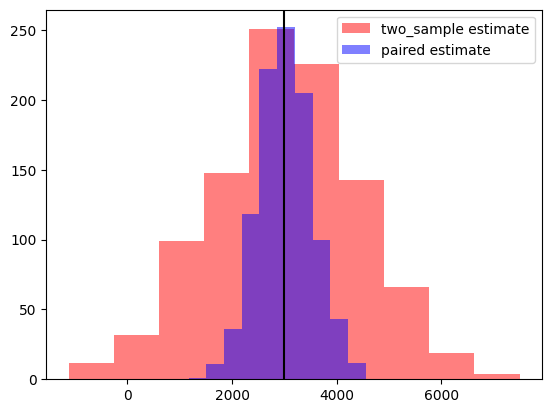

In [15]:
plt.hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
plt.axvline(te, color='black')
plt.legend(loc='upper right') 
plt.show() 

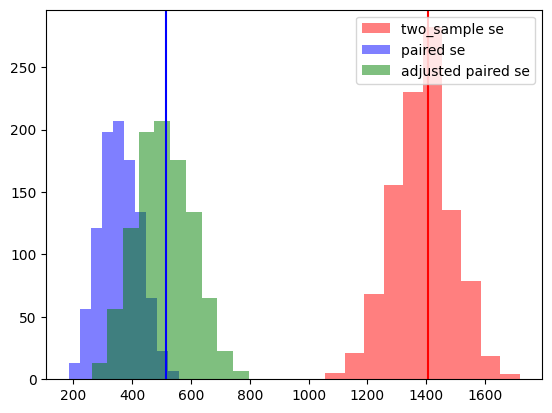

In [16]:
plt.hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

plt.hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
plt.legend(loc='upper right') 
plt.axvline(np.std(sim_res['two_est'],ddof=1), color='red')
plt.axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

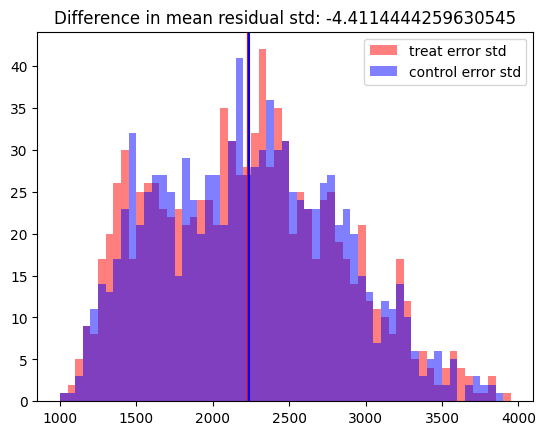

In [17]:
# check if distribution of residuals are the same between control and treat group
plt.hist(np.sqrt(sim_res['error1']),  bins = range(1000,4000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

plt.hist(np.sqrt(sim_res['error0']),  bins = range(1000,4000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
plt.legend(loc='upper right') 
plt.axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
plt.axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
plt.title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

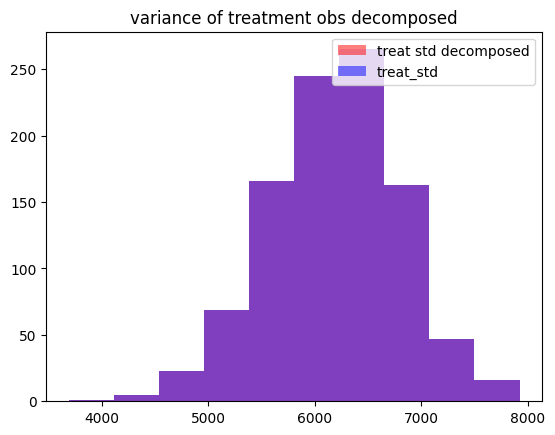

In [18]:
# check if variance decomposition for two sample test aligns
plt.hist(np.sqrt(sim_res['treat_pred_var'] + sim_res['error1'] + sim_res['treat_covar']),  
             alpha=0.5,  
             label='treat std decomposed', 
             color='red') # customized color parameter 

plt.hist(np.sqrt(sim_res['treat_var']),  
             alpha=0.5,  
             label='treat_std', 
             color='blue') # customized color parameter 
plt.legend(loc='upper right') 
#plt.axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
#plt.axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
plt.title("variance of treatment obs decomposed")
plt.show() 

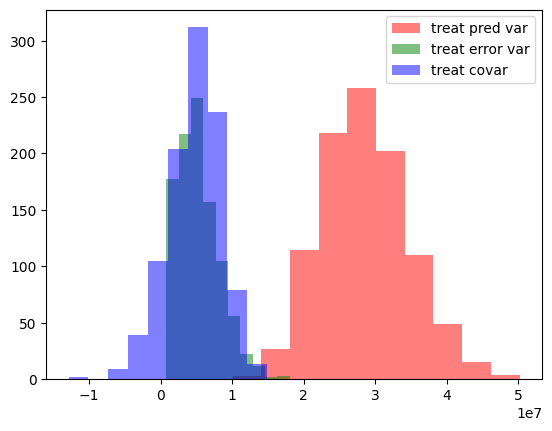

In [19]:
plt.hist(sim_res['treat_pred_var'],  
             alpha=0.5,  
             label='treat pred var', 
             color='red') # customized color parameter 

plt.hist(sim_res['error1'],  
             alpha=0.5,  
             label='treat error var', 
             color='green') # customized color parameter 

plt.hist(sim_res['treat_covar'],  
             alpha=0.5,  
             label='treat covar', 
             color='blue') # customized color parameter 
plt.legend()
plt.show()


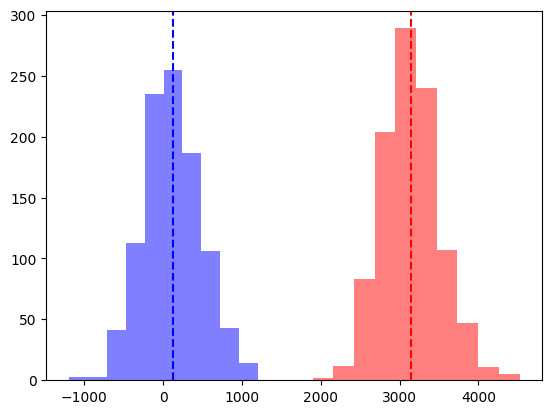

In [21]:
plt.hist(sim_res['alpha0'],
        alpha=0.5,
        label='alpha0',
        color='blue')
plt.axvline(np.mean(sim_res['alpha0']), color='blue',linestyle='--')
plt.hist(sim_res['alpha1'],
        alpha=0.5,
        label='alpha1',
        color='red')
plt.axvline(np.mean(sim_res['alpha1']), color='red',linestyle='--')

plt.show()

In [15]:
# train multiple models with same hyper parameters to generate multiple predictions for the test data
# each time, sample with replacement from the train data of the same size
random.seed(1)
np.random.seed(1)
pred_res = []
num_preds = 1000
y_train = y_train.reset_index(drop=True)
n = len(y_train)
index_range = range(n)

for i in range(num_preds):
    # sample train data with replacement from original train data
    bs_index = random.choices(indx_range, k=n)
    X_train_bs = X_train[bs_index,]
    y_train_bs = y_train[bs_index]
    # fit xgb model with the train data
    xgb_bs = XGBRegressor(max_depth = 4, min_child_weight = 1, n_estimators = 81, learning_rate =0.1, subsample=0.8, 
                          colsample_bytree=0.8, scale_pos_weight=1, seed=10)
    xgb_bs.fit(X_train_bs, y_train_bs)
    # generate predictions
    bs_pred = xgb_bs.predict(X_test)
    pred_res.append(bs_pred)

bs_preds = pd.DataFrame(pred_res,columns = range(len(y_test)))
bs_preds.describe()


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,22423.152344,16994.220703,24761.908203,28739.400391,16679.470703,28149.572266,17054.775391,38633.945312,15209.490234,24975.369141,...,25870.644531,23171.892578,26595.505859,23685.789062,27246.203125,22287.833984,18887.076172,25245.933594,28522.787109,27828.042969
std,319.693848,820.937012,1160.816284,823.152100,878.706177,420.793701,955.401672,1070.863525,502.088898,591.428345,...,432.979401,487.103455,1002.450317,602.475830,314.412323,243.752625,1006.693542,730.490967,284.064178,608.859009
min,21278.203125,15270.447266,21228.535156,26653.566406,14906.562500,27034.587891,14442.535156,34036.507812,12911.073242,22712.564453,...,24363.123047,21835.378906,23838.683594,22140.363281,26136.257812,21471.306641,16003.356445,23344.404297,27833.574219,26057.205078
25%,22223.247559,16436.292969,23990.755859,28170.627441,16054.814941,27862.040039,16443.070801,37990.561523,14895.733154,24580.968750,...,25572.961426,22830.762695,25912.544922,23278.836914,27045.618164,22139.500488,18261.942871,24728.049805,28323.006836,27410.219238
50%,22436.781250,16874.644531,24725.281250,28679.798828,16533.862305,28110.091797,17052.261719,38635.978516,15164.643555,24977.233398,...,25840.341797,23133.456055,26541.458984,23632.458008,27259.757812,22290.866211,18785.134766,25267.724609,28492.248047,27821.864258
75%,22626.049316,17443.062012,25475.557617,29267.824219,17107.008301,28381.500488,17657.722656,39308.923828,15477.409424,25389.756836,...,26121.726074,23458.725586,27190.489258,24085.204590,27469.306152,22451.636719,19363.661133,25716.738281,28693.804199,28243.091797
max,23617.648438,21156.599609,28794.363281,31389.966797,20999.863281,30230.064453,21244.794922,42892.695312,17904.880859,26923.150391,...,27418.964844,25209.179688,30528.462891,26155.425781,28079.738281,23136.453125,26955.474609,27500.769531,30118.845703,30468.496094


count     198.000000
mean      796.603088
std       626.511902
min       196.151505
25%       423.666580
50%       597.440582
75%       877.819031
max      3401.318604
dtype: float64

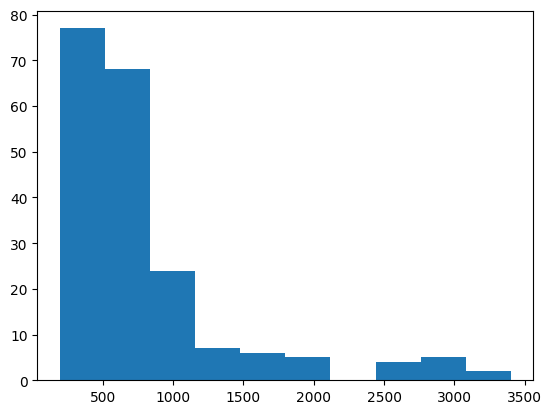

In [16]:
pred_stds = np.std(bs_preds, ddof=1, axis=0)
pred_stds
plt.hist(pred_stds)
pred_stds.describe()

In [17]:
# considering variance in model

# assume you are randomly assigning incoming stream of observations to treatment or control
# each observation in the stream is randomly chosen with replacement from the remaining data (X_ab, y_ab)
# if treatment, add constant te to y_ab, otherwise leave it

random.seed(1)
np.random.seed(1)
# treatment effect (constant)
temp_res = []
sample_size = 50
indx_range = range(0,len(y_test))
for i in range(num_preds):
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    predictions = pred_res[i]
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1","alpha1","alpha0","error1","error0"])
    

In [18]:
sim_res.describe()

,two_est,two_se,pair_est,pair_se,pair_se_est1,alpha1,alpha0,error1,error0
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,2995.760000,1242.490603,3006.087752,515.174044,732.273860,2641.941739,-364.146001,1.376267e+07,1.358045e+07
std,1302.518244,79.568563,773.569468,72.596598,103.189576,564.909054,547.379872,5.569466e+06,5.067300e+06
min,-980.000000,1016.263665,183.960771,314.898408,447.599943,82.951602,-2091.029727,2.383569e+06,3.292848e+06
25%,2140.000000,1187.685109,2520.486875,465.424867,661.559852,2305.505200,-719.597715,9.689684e+06,1.000186e+07
50%,3020.000000,1244.073293,3020.357065,514.189980,730.875089,2652.783320,-354.914795,1.301425e+07,1.290457e+07
75%,3865.000000,1294.184007,3508.547349,560.912111,797.286439,3006.282725,14.691479,1.682316e+07,1.641355e+07
max,6760.000000,1477.010218,5558.886016,718.329960,1021.041844,4646.355684,1417.537852,3.811840e+07,3.585279e+07


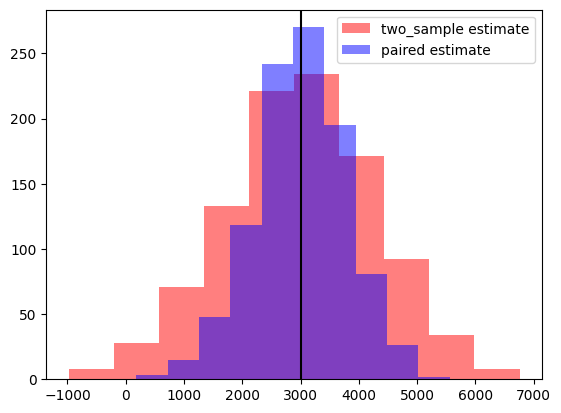

In [19]:
plt.hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
plt.axvline(te, color='black')
plt.legend(loc='upper right') 
plt.show() 

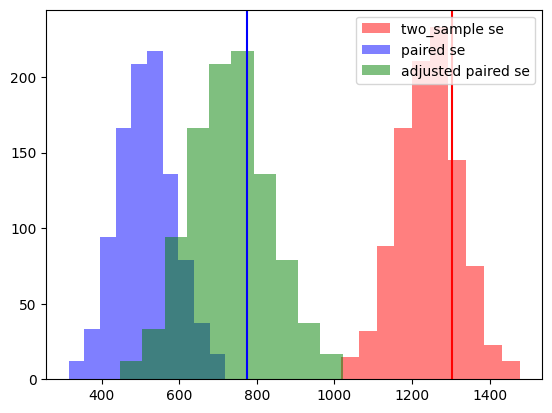

In [20]:
plt.hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

plt.hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
plt.legend(loc='upper right') 
plt.axvline(np.std(sim_res['two_est'],ddof=1), color='red')
plt.axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

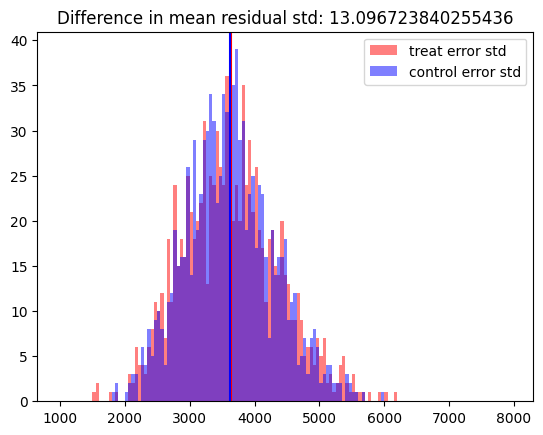

In [22]:
# check if distribution of residuals are the same between control and treat group
plt.hist(np.sqrt(sim_res['error1']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

plt.hist(np.sqrt(sim_res['error0']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
plt.legend(loc='upper right') 
plt.axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
plt.axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
plt.title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

Misalignment with two sample se distribution and the observed standard dev of two sample TE estimates... is this due to sampling with replacement? (when sample size is 50, biased, when its 40 or lower, unbiased estimate of se... maybe check size of test data - does 50 treatment and 50 control give overlap in data? 
- it doesn't, test data has 198 points. 50 just seems to be an odd one out? 40 works fine, 80 works fine, 90 slightly same effect... why? test with different sample sizes and see if there is a relationship

In [23]:
# generate multiple simulations with different sample sizes, confirm that this is just by chance and not a trend with 
# respect to the sample size 
random.seed(12312343)
np.random.seed(9834023)
# treatment effect (constant)
sample_sizes = range(10,100,1)
indx_range = range(0,len(y_test))
se_bias_res = []
for j in range(len(sample_sizes)):
    temp_res = []
    for i in range(num_preds):
        control_idx = random.choices(indx_range, k=sample_size)
        treat_idx = random.choices(indx_range, k=sample_size)
        control_x = X_test[control_idx,]
        treat_x = X_test[treat_idx,]
        control_y = y_test[control_idx]
        treat_y = y_test[treat_idx] + te
        predictions = pred_res[i]
        alpha1 = np.mean(treat_y - predictions[treat_idx])
        alpha0 = np.mean(control_y - predictions[control_idx])
        error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
        error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
        synt_treat_obs = predictions[control_idx] + alpha1
        synt_control_obs = predictions[treat_idx] + alpha0
        se_est1 = (error1/sample_size + error0/sample_size)**0.5
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
        temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0])
    sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1","alpha1","alpha0","error1","error0"])
    se_bias_res.append([np.std(sim_res["two_est"], ddof=1) - np.mean(sim_res["two_se"]),
                       np.std(sim_res["pair_est"], ddof=1) - np.mean(sim_res["pair_se_est1"]),
                       np.std(sim_res["pair_est"], ddof=1) - np.mean(sim_res["pair_se"])])

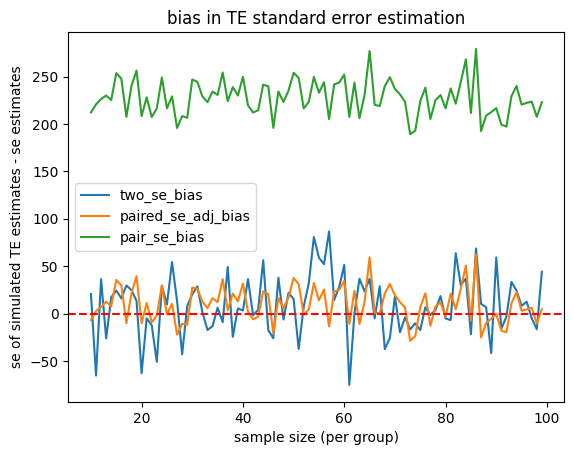

In [25]:
se_bias_df = pd.DataFrame(se_bias_res, columns=["two_se_bias", "pair_se_adj_bias","pair_se_bias"])
plt.plot(sample_sizes, se_bias_df["two_se_bias"], label = "two_se_bias")
plt.plot(sample_sizes, se_bias_df["pair_se_adj_bias"], label = "paired_se_adj_bias")
plt.plot(sample_sizes, se_bias_df["pair_se_bias"], label = "pair_se_bias")
plt.axhline(0,color='red',linestyle='--')
plt.title("bias in TE standard error estimation")
plt.xlabel("sample size (per group)")
plt.ylabel("se of simulated TE estimates - se estimates")
plt.legend()
plt.show()

Thankfully, it appears that there is no exact trend with this, especially when increasing the range of sample sizes to get a wider view. it just seems that there are some sample sizes that produce certain over/under estimates in se, but on average this is 0. changing seed changes the graph of biases, so can attribute this to randomness. Maybe use sample size 80 just to keep the noise out. 

Back to the original problem, let's try estimating prediction variance with the simulated predictions, and then incorporate it into the TE variance. 

In [26]:
# re-simulate results with sample size 80
random.seed(1)
np.random.seed(1)
prediction_vars = np.var(bs_preds, axis=0, ddof=1)
temp_res = []
sample_size = 80
indx_range = range(0,len(y_test))
for i in range(num_preds):
    # sample with replacement for control and treatment obs
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    # simulate treatment outcomes by adding constant te
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    # choose a random simulation to compute parameters on
    predictions = pred_res[i]
    # compute params
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    # estimated paired test te se
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    # generate combined observations for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test te and se
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    # paired test te and se
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
    # calculate prediction variances to use, based on the observations sampled
    control_mean_pred_var = np.mean(prediction_vars[control_idx])
    treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
    # store results
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                    control_mean_pred_var, treat_mean_pred_var])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                          "alpha1","alpha0","error1","error0",
                                          "control_pred_var","treat_pred_var"])    

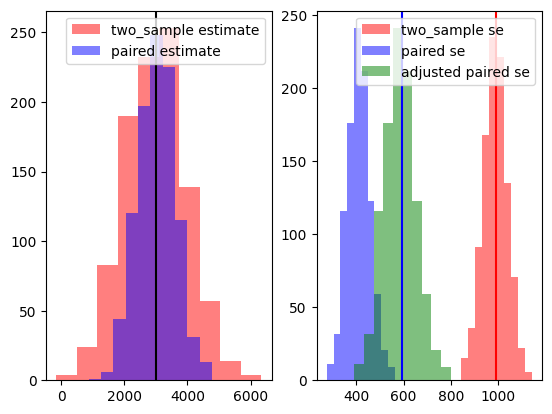

In [27]:
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
 
ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

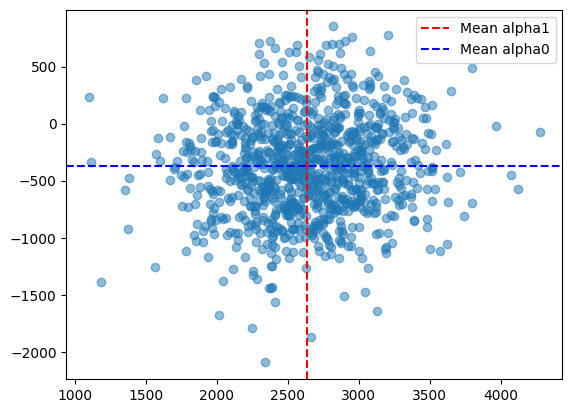

array([[1.       , 0.0818661],
       [0.0818661, 1.       ]])

In [28]:
# Let's first check covariance between alpha1 and alpha0
plt.scatter(sim_res['alpha1'], sim_res['alpha0'], alpha = 0.5)
plt.axvline(np.mean(sim_res['alpha1']), color='red', linestyle = "--", label = "Mean alpha1")
plt.axhline(np.mean(sim_res['alpha0']), color='blue', linestyle = "--", label = "Mean alpha0")
plt.legend()
plt.show()
np.corrcoef(sim_res['alpha1'], sim_res['alpha0'])

Insignificant correlation between alpha1 and alpha0 as expected, and no visible pattern between the two on the plot. Let's see how the actual TE variance compares to the estimate calculated as the sum of variance of alpha1 and alpha0.

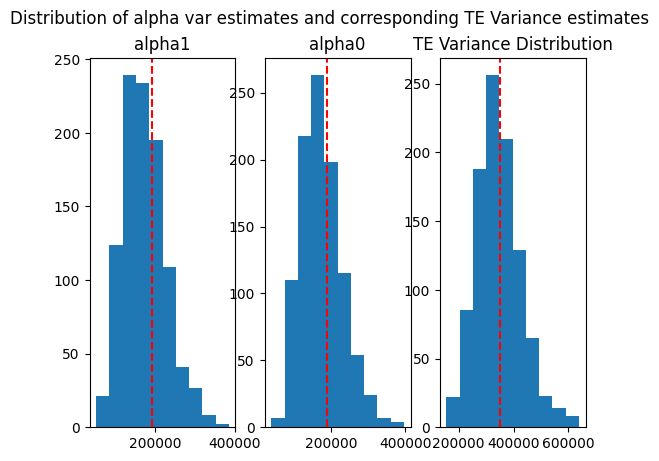

In [29]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates")
plt.show()

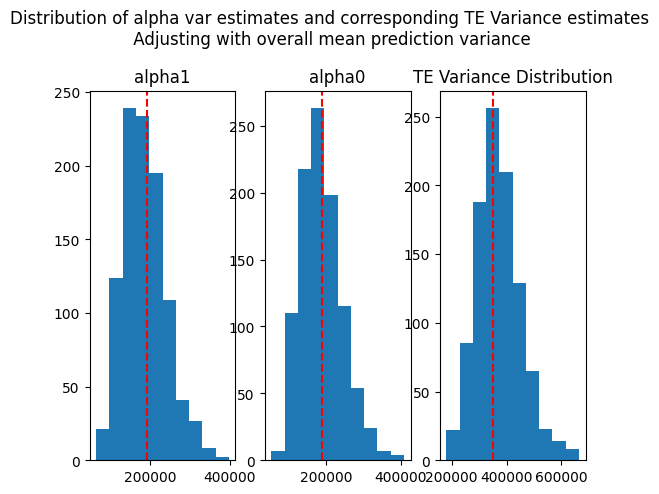

In [30]:
pred_var_est = np.mean(np.var(bs_preds, axis=0, ddof=1))
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + pred_var_est/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + pred_var_est/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size + 2*pred_var_est/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with overall mean prediction variance",
            y = 1.05)
plt.show()

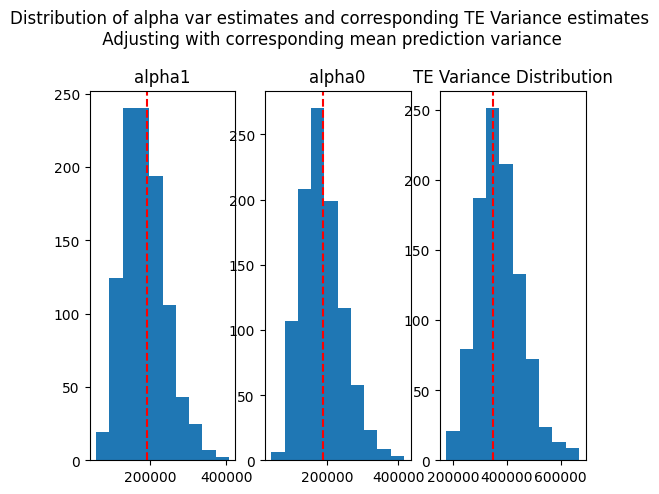

In [31]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size
            + sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with corresponding mean prediction variance",
            y = 1.05)
plt.show()

Adjusting for prediction variance using predictions from multiple models gives more accurate estimates of treatment effect variances. Now, is this just because I am varying the predictions in my simulation? What happens if I just use a single simulation and generate the above plots again?

In [32]:
# re-simulate results but only using 1 set of predictions from the original model
random.seed(1)
np.random.seed(1)
temp_res = []
sample_size = 80
indx_range = range(0,len(y_test))
predictions = gs1.predict(X_test)
for i in range(num_preds):
    # sample with replacement for control and treatment obs
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    # simulate treatment outcomes by adding constant te
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    # compute params
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    # estimated paired test te se
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    # generate combined observations for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test te and se
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    # paired test te and se
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
    # calculate prediction variances to use, based on the observations sampled
    control_mean_pred_var = np.mean(prediction_vars[control_idx])
    treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
    # store results
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                    control_mean_pred_var, treat_mean_pred_var])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                          "alpha1","alpha0","error1","error0",
                                          "control_pred_var","treat_pred_var"])

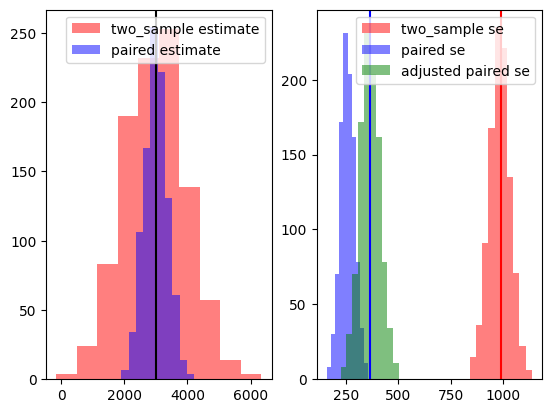

In [33]:
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
 
ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

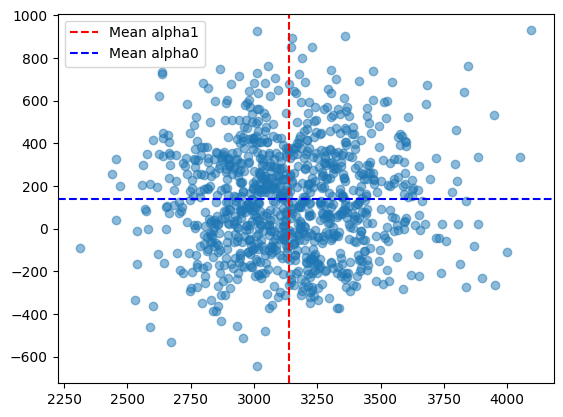

array([[1.        , 0.03117192],
       [0.03117192, 1.        ]])

In [34]:
# check for correlation between alpha1 and alpha0 again
plt.scatter(sim_res['alpha1'], sim_res['alpha0'], alpha = 0.5)
plt.axvline(np.mean(sim_res['alpha1']), color='red', linestyle = "--", label = "Mean alpha1")
plt.axhline(np.mean(sim_res['alpha0']), color='blue', linestyle = "--", label = "Mean alpha0")
plt.legend()
plt.show()
np.corrcoef(sim_res['alpha1'], sim_res['alpha0'])

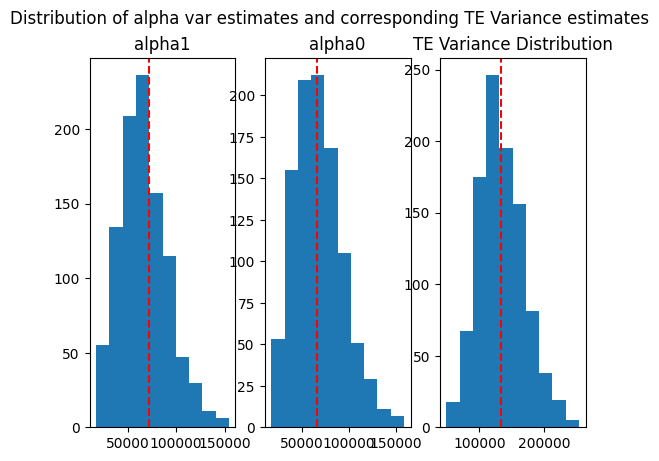

In [35]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates")
plt.show()

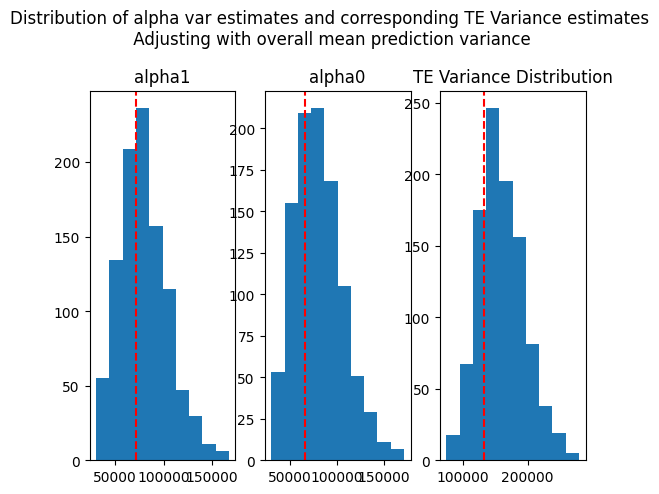

In [36]:
pred_var_est = np.mean(np.var(bs_preds, axis=0, ddof=1))
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + pred_var_est/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + pred_var_est/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size + 2*pred_var_est/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with overall mean prediction variance",
            y = 1.05)
plt.show()

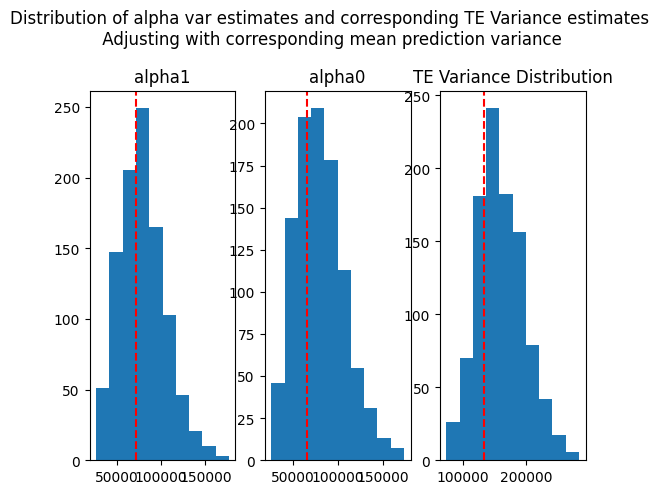

In [37]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size
            + sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with corresponding mean prediction variance",
            y = 1.05)
plt.show()

When only using single set of predictions, adjusting for prediction variance seems to OVERestimate the treatment effect variance, as well as the variances of alphas. Of course, this is reasonable considering that there is less randomness in simulation, with the predictions staying constant across all iterations. In practice, only using one set of predictions would give too optimistic results, because it doesn't take into account of the sampling variance. 

Explore the effect of unbalanced group sizes to treatment effect estimation. Run simulation with different sizes for treatment and control group, and compare the results.

In [46]:
# generate multiple simulations with different group proportions
random.seed(1)
np.random.seed(1)
treat_prop = np.arange(0.1,1,0.1)
sample_size = 80 * 2 # this is the total sample size across both groups. before it was 80 per group but now 160 will be 
# distributed at different rates to each group
indx_range = range(0,len(y_test))
sim_res_df_dic = {}
for j in range(len(treat_prop)):
    temp_res = []
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    for i in range(num_preds):
        control_idx = random.choices(indx_range, k=control_size)
        treat_idx = random.choices(indx_range, k=treat_size)
        control_x = X_test[control_idx,]
        treat_x = X_test[treat_idx,]
        control_y = y_test[control_idx]
        treat_y = y_test[treat_idx] + te
        predictions = pred_res[i]
        alpha1 = np.mean(treat_y - predictions[treat_idx])
        alpha0 = np.mean(control_y - predictions[control_idx])
        error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
        error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
        synt_treat_obs = predictions[control_idx] + alpha1
        synt_control_obs = predictions[treat_idx] + alpha0
        se_est1 = (error1/treat_size + error0/control_size)**0.5
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        two_sample_se = ((1/treat_size + 1/control_size)
                         *(np.var(treat_y, ddof=1)*(treat_size-1) + np.var(control_y, ddof=1)*(control_size-1))
                         /(sample_size - 2))**0.5
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
        # calculate prediction variances to use, based on the observations sampled
        control_mean_pred_var = np.mean(prediction_vars[control_idx])
        treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
        # store results
        temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                        control_mean_pred_var, treat_mean_pred_var])
        sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                                  "alpha1","alpha0","error1","error0",
                                                  "control_pred_var","treat_pred_var"])
    sim_res_df_dic[treat_prop[j]] = sim_res

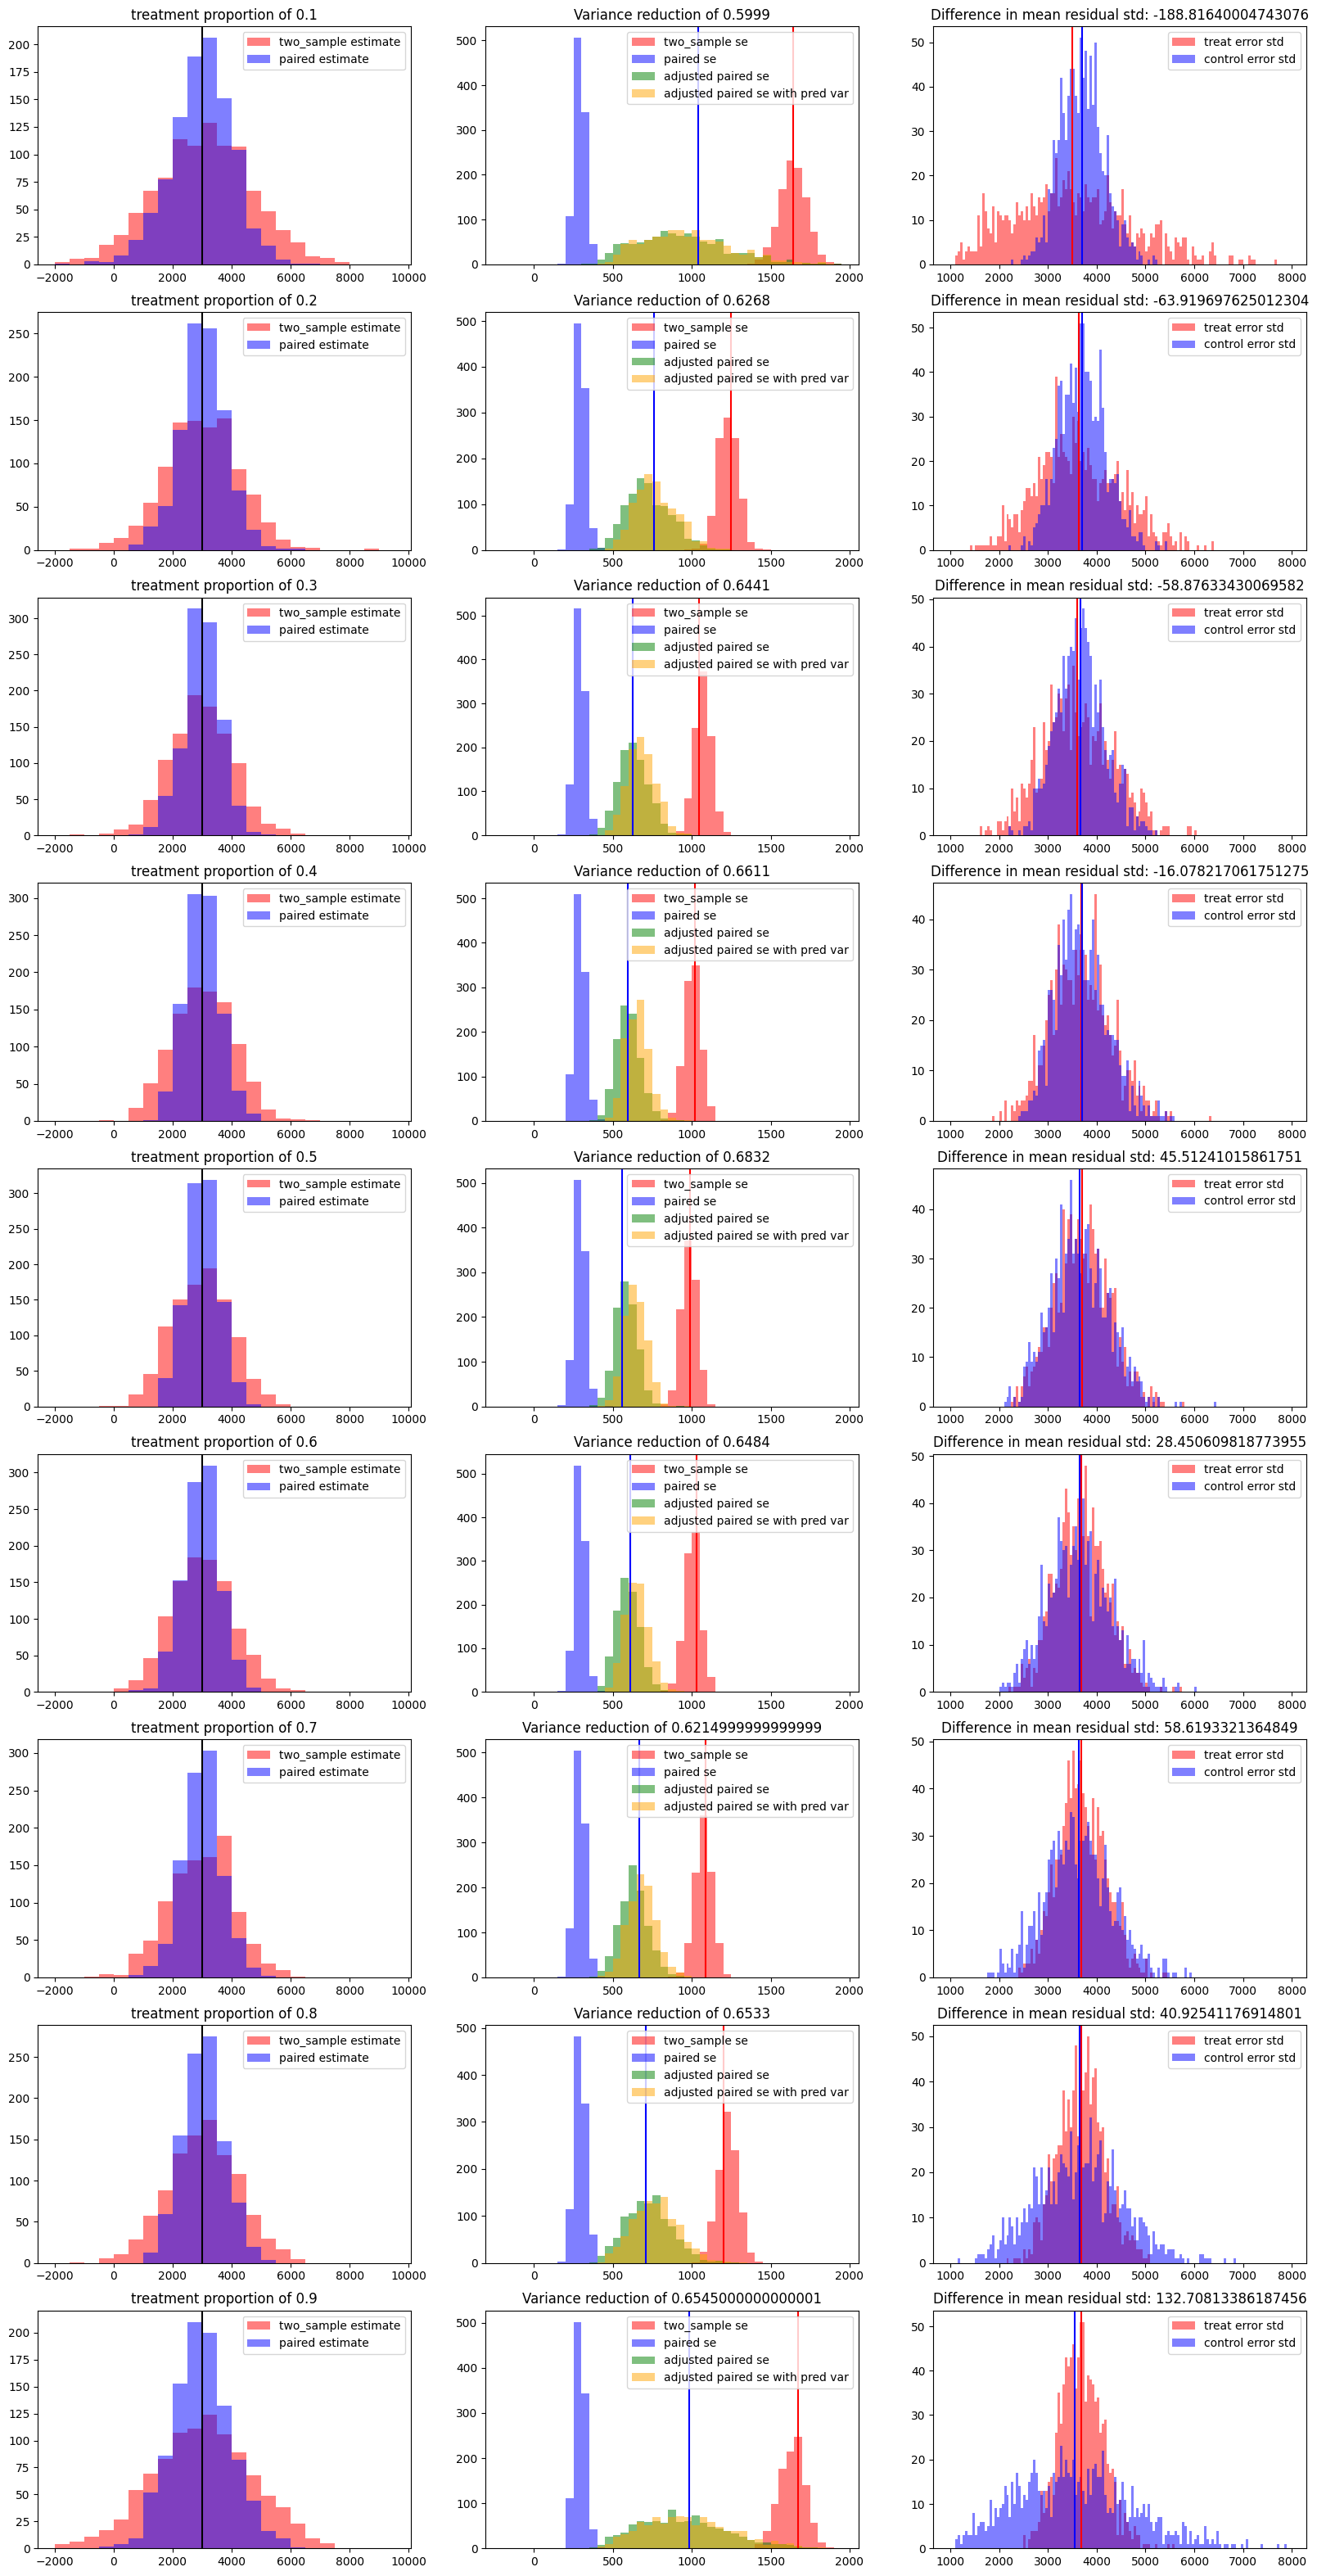

In [47]:
plt.rcParams['figure.figsize'] = [20, 40]
fig, ax = plt.subplots(len(treat_prop), 3)
for j in range(len(treat_prop)):
    sim_res = sim_res_df_dic[treat_prop[j]]
    ax[j,0].hist(sim_res['two_est'], bins = range(-2000,10000,500), 
             alpha=0.5,  
             label='two_sample estimate', 
             color='red') # customized color parameter 

    ax[j,0].hist(sim_res['pair_est'], bins = range(-2000,10000,500),   
             alpha=0.5,  
             label='paired estimate', 
             color='blue') # customized color parameter 
    ax[j,0].axvline(te, color='black')
    ax[j,0].legend() 
    ax[j,0].set_title("treatment proportion of " + str(round(treat_prop[j],1)))

    ax[j,1].hist(sim_res['two_se'],  bins = range(-200,2000,50),   
             alpha=0.5,  
             label='two_sample se', 
             color='red') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se'],  bins = range(-200,2000,50), 
             alpha=0.5,  
             label='paired se', 
             color='blue') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se_est1'],bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se',
            color='green')
    ax[j,1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
    ax[j,1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
    
    # note that the plot is for SE, not variance. But, plotting variance really messes up the scale alot so using se instead. 
    ax[j,1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
    ax[j,1].hist(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                         + sim_res['treat_pred_var']/treat_size
                         + sim_res['control_pred_var']/control_size),
            bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se with pred var',
            color='orange')
    ax[j,1].legend() 
    ax[j,2].hist(np.sqrt(sim_res['error1']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

    ax[j,2].hist(np.sqrt(sim_res['error0']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
    ax[j,2].legend() 
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
    ax[j,2].set_title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

More balanced samples tend to give more variance reduction, and generally lower TE variance. Makes sense, because unbalanced means there is more randomness associated with TE, where the unbalance is contributing something to the TE estimation. However, variance reduction is still meaningful in all cases. Now, let's try plotting results with the prediction variance adjustments in place. 

Also, the variance of residuals differs as proportions change. This makes sense, as smaller sample size would mean more spread out variance distribution. When treatment proportion is low (0.1), the variance of treatment residuals are much more spread out than that of control residuals. When treatment proportion is high (0.9), the variance of control residuals is much more spread out than that of treatment residuals.

TBH, prediction var adjustment doesnt look like it does much significant stuff... Let's compare the numbers themselves to see how well the actual TE variance lines up with the estimated distribution of TE, with and without the prediction var into account.

In [48]:
temp_res = []
for i in range(len(treat_prop)):
    treat_size = int(sample_size*treat_prop[i])
    control_size = sample_size - treat_size
    sim_res = sim_res_df_dic[treat_prop[i]]
    pair_se = np.std(sim_res['pair_est'],ddof=1)
    two_se = np.std(sim_res['two_est'],ddof=1)
    est_two_se_mean = np.mean(sim_res['two_se'])
    est_two_se_med = np.median(sim_res['two_se'])
    est_pair_se_mean = np.mean(sim_res['pair_se_est1'])
    est_pair_se_med = np.median(sim_res['pair_se_est1'])
    est_pair_se_mean_adj = np.mean(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                                            + sim_res['treat_pred_var']/treat_size
                                            + sim_res['control_pred_var']/control_size))
    est_pair_se_med_adj = np.median(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                                            + sim_res['treat_pred_var']/treat_size
                                            + sim_res['control_pred_var']/control_size))
    temp_res.append([two_se,
                     est_two_se_mean, est_two_se_med,
                     pair_se,
                     est_pair_se_mean, est_pair_se_med,
                     est_pair_se_mean_adj, est_pair_se_med_adj])
te_se_stat = pd.DataFrame(temp_res, columns = ['simulated_two_se',
                                              'estimated_two_se_mean','estimated_two_se_med',
                                               'simulated_pair_se',
                                              'estimated_pair_se_mean','estimated_pair_se_med',
                                              'estimated_pair_se_mean_adj','estimated_pair_se_med_adj'])
te_se_stat
                 

,simulated_two_se,estimated_two_se_mean,estimated_two_se_med,simulated_pair_se,estimated_pair_se_mean,estimated_pair_se_med,estimated_pair_se_mean_adj,estimated_pair_se_med_adj
0,1641.642191,1641.862438,1642.734104,1038.348948,935.794455,911.129829,973.222108,944.074703
1,1246.282079,1228.768646,1229.391843,761.392874,726.194994,710.236989,753.436527,738.237361
2,1047.990983,1070.889636,1070.802462,625.161221,629.205364,621.590921,652.744978,645.557339
3,1021.978168,1004.962625,1005.017276,594.915270,597.926077,595.596169,619.970218,617.155490
4,987.284354,983.323411,982.546964,555.717476,584.288589,582.401362,606.026194,603.136560
5,1029.547108,1003.767012,1004.099067,610.455153,594.502652,591.776370,616.569902,613.235496
6,1086.201897,1073.582430,1073.064661,668.233581,632.733207,631.297840,656.386641,653.960362
7,1201.621436,1228.855344,1230.570385,707.496789,725.664478,723.569427,753.341293,749.838477
8,1675.249620,1637.207196,1639.689703,984.645853,947.055285,928.493521,984.422583,964.230074


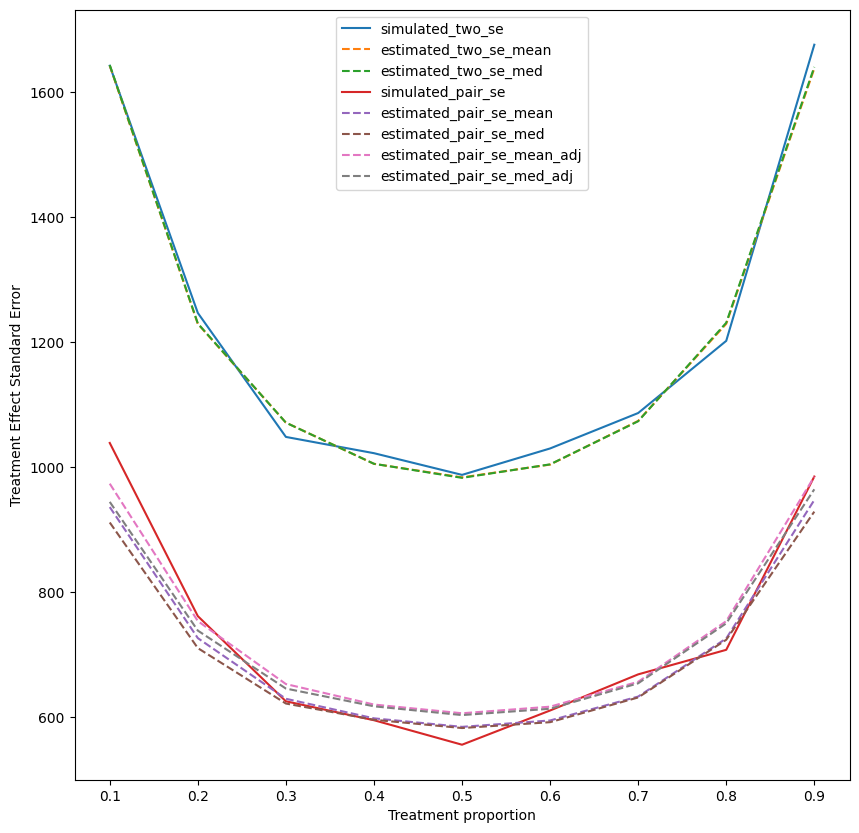

In [49]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(treat_prop, te_se_stat['simulated_two_se'], label = 'simulated_two_se')
plt.plot(treat_prop, te_se_stat['estimated_two_se_mean'], linestyle = "--", label = 'estimated_two_se_mean')
plt.plot(treat_prop, te_se_stat['estimated_two_se_med'], linestyle = "--", label = 'estimated_two_se_med')
plt.plot(treat_prop, te_se_stat['simulated_pair_se'], label = 'simulated_pair_se')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_mean'], linestyle = "--", label = 'estimated_pair_se_mean')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_med'], linestyle = "--", label = 'estimated_pair_se_med')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_mean_adj'], linestyle = "--", label = 'estimated_pair_se_mean_adj')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_med_adj'], linestyle = "--", label = 'estimated_pair_se_med_adj')
plt.xlabel("Treatment proportion")
plt.ylabel("Treatment Effect Standard Error")
plt.legend()
plt.show()

Firstly, it looks like balanced test definitely has much more reduced TE SE compared to unbalanced test. This makes sense because the variance of TE estimator has the least variance when all sample sizes are equal (take derivative in terms of treatment size x where control size is n-x). Also, it looks like the estimated se for paired tests tend to slightly underestimate SE when unbalanced but overestimate SE when balanced. 

What happens in the case of unequal variance? For example, what if treatment effect has some distribution with mean being the true treatment effect and some variance, hence the treatment outcomes have wider spread compared to control outcomes? 

In [50]:
# sample treatment effect  from a normal distribution with some variance
random.seed(1)
np.random.seed(1)
treat_prop = np.arange(0.1,1,0.1)
sample_size = 80 * 2 # this is the total sample size across both groups. before it was 80 per group but now 160 will be 
# distributed at different rates to each group
indx_range = range(0,len(y_test))
sim_res_df_dic = {}
mean_te = 3000
te_std = 500
for j in range(len(treat_prop)):
    temp_res = []
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    for i in range(num_preds):
        control_idx = random.choices(indx_range, k=control_size)
        treat_idx = random.choices(indx_range, k=treat_size)
        control_x = X_test[control_idx,]
        treat_x = X_test[treat_idx,]
        control_y = y_test[control_idx]
        treat_y = y_test[treat_idx] + stats.norm.rvs(size = treat_size, loc = mean_te, scale = te_std)
        predictions = pred_res[i]
        alpha1 = np.mean(treat_y - predictions[treat_idx])
        alpha0 = np.mean(control_y - predictions[control_idx])
        error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
        error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
        synt_treat_obs = predictions[control_idx] + alpha1
        synt_control_obs = predictions[treat_idx] + alpha0
        se_est1 = (error1/treat_size + error0/control_size)**0.5
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        two_sample_se = ((1/treat_size + 1/control_size)
                         *(np.var(treat_y, ddof=1)*(treat_size-1) + np.var(control_y, ddof=1)*(control_size-1))
                         /(sample_size - 2))**0.5
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
        # calculate prediction variances to use, based on the observations sampled
        control_mean_pred_var = np.mean(prediction_vars[control_idx])
        treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
        # store results
        temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                        control_mean_pred_var, treat_mean_pred_var])
    sim_res_df_dic[treat_prop[j]] = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                                  "alpha1","alpha0","error1","error0",
                                                  "control_pred_var","treat_pred_var"])

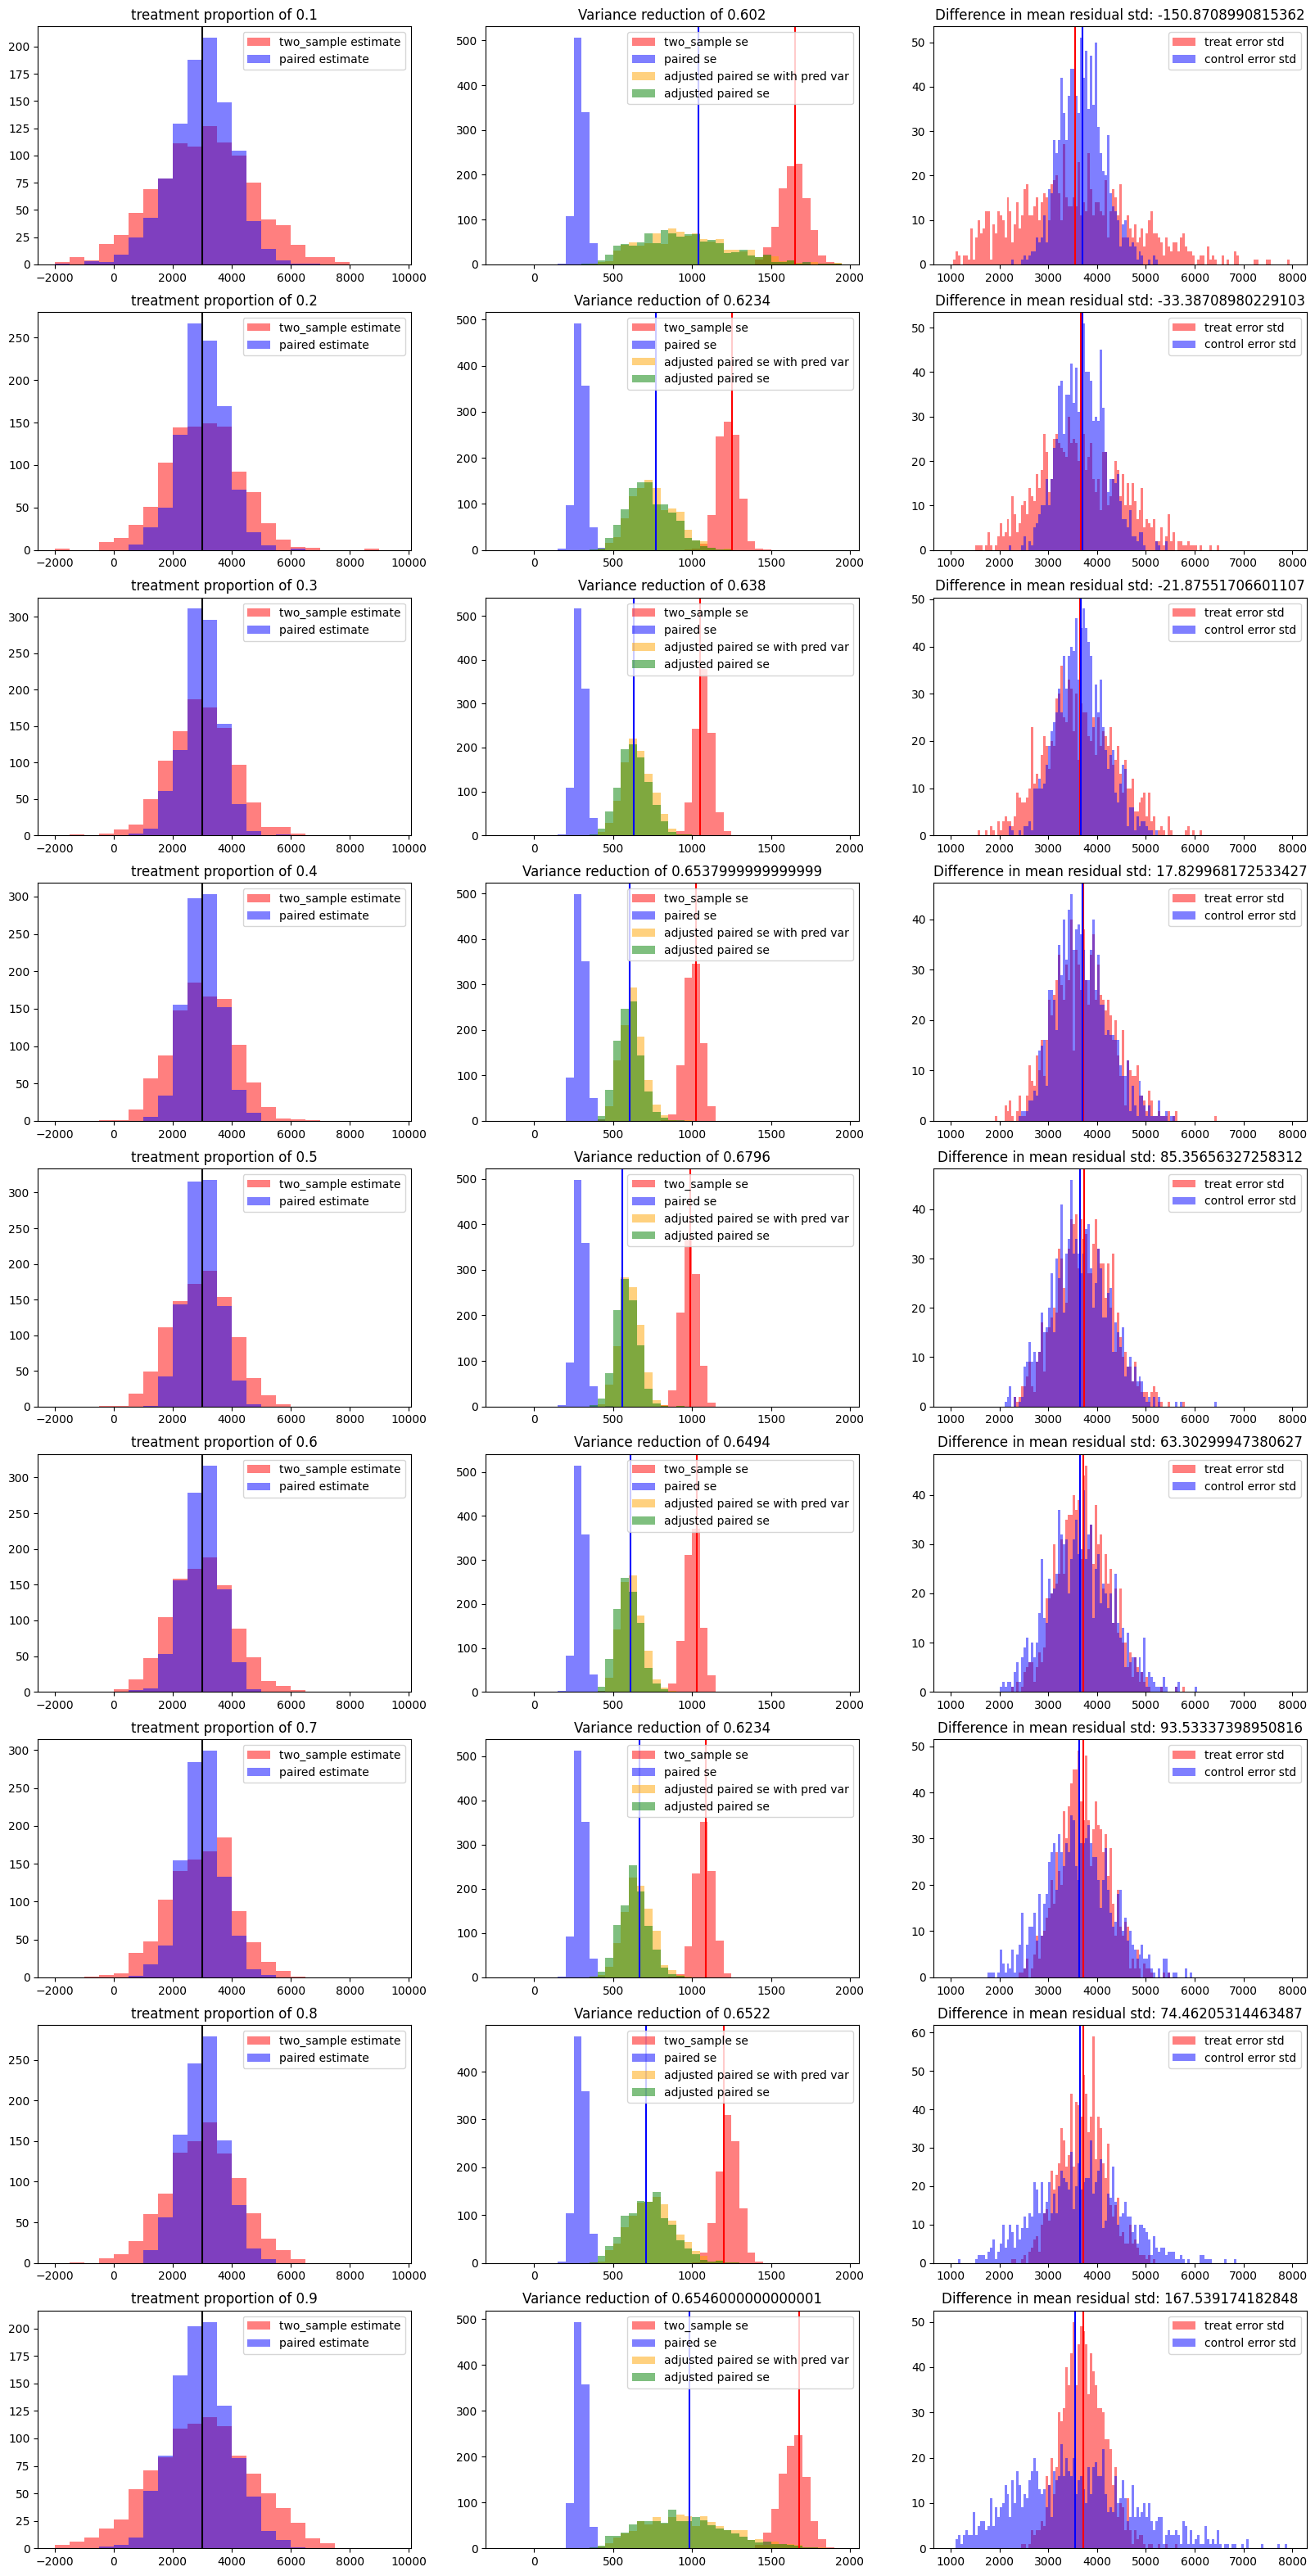

In [51]:
plt.rcParams['figure.figsize'] = [20, 40]
fig, ax = plt.subplots(len(treat_prop), 3)
for j in range(len(treat_prop)):
    sim_res = sim_res_df_dic[treat_prop[j]]
    ax[j,0].hist(sim_res['two_est'], bins = range(-2000,10000,500), 
             alpha=0.5,  
             label='two_sample estimate', 
             color='red') # customized color parameter 

    ax[j,0].hist(sim_res['pair_est'], bins = range(-2000,10000,500),   
             alpha=0.5,  
             label='paired estimate', 
             color='blue') # customized color parameter 
    ax[j,0].axvline(mean_te, color='black')
    ax[j,0].legend(loc='upper right') 

    ax[j,1].hist(sim_res['two_se'],  bins = range(-200,2000,50),   
             alpha=0.5,  
             label='two_sample se', 
             color='red') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se'],  bins = range(-200,2000,50), 
             alpha=0.5,  
             label='paired se', 
             color='blue') # customized color parameter 
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    ax[j,1].hist(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                         + sim_res['treat_pred_var']/treat_size
                         + sim_res['control_pred_var']/control_size),
            bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se with pred var',
            color='orange')
    ax[j,1].hist(sim_res['pair_se_est1'],
            bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se',
            color='green')
    ax[j,1].legend(loc='upper right') 
    ax[j,1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
    ax[j,1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
    ax[j,0].set_title("treatment proportion of " + str(round(treat_prop[j],1)))
    ax[j,1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
    
    # check if variance/std of residuals are the same between control and treat group
    ax[j,2].hist(np.sqrt(sim_res['error1']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

    ax[j,2].hist(np.sqrt(sim_res['error0']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
    ax[j,2].legend(loc='upper right') 
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
    ax[j,2].set_title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

The difference in mean residual std seems to have shifted positively. This makes sense - since only treatment group variance is increased by adding randomness to treatment effect applied, then the difference between std of treatment residuals and std of control residuals should become more positive. 

## Need to adjust for covariate proportions (basically propensity score) when calculating two sample var
Now let's explore how the method works if treatment is assigned with covariates not being balanced. This will be simulated by first identifying important features by looking at feature importance metrics from the original model. Then, treatment assignment will be made disproportionately with respect to one or more of the most important features, so that treatment group has most (or almost none) of a particular value of important features. For example, if number of surgeries is a very important variable, treatment group would contain mostly those people who has non-zero number of surgeries, whereas there is almost no one who has had surgeries before in the control group.


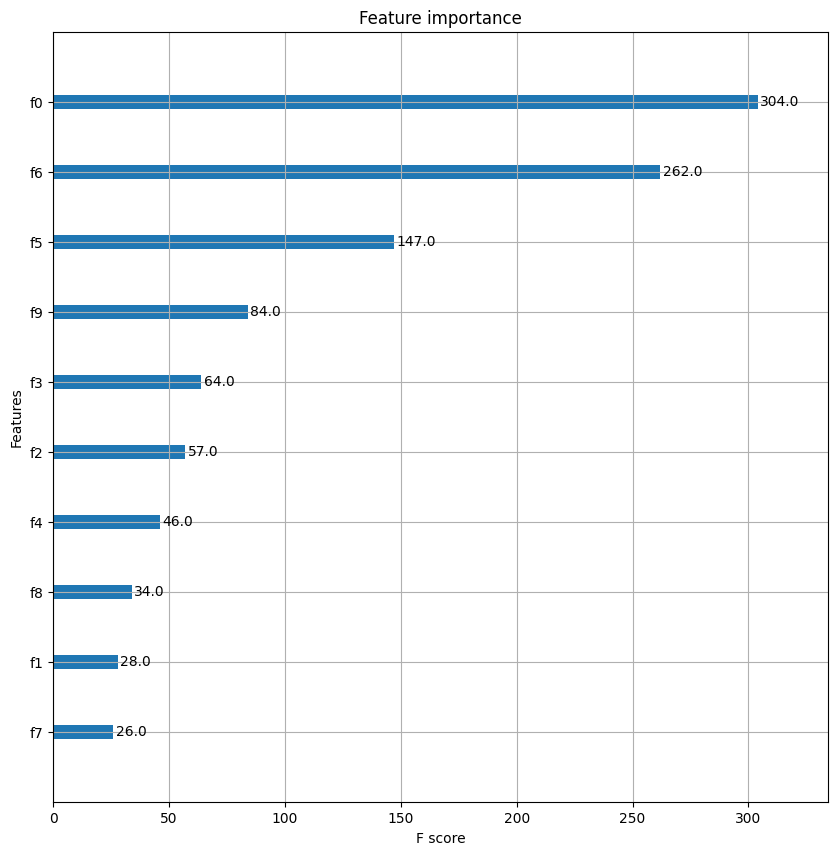

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')


In [56]:
# plot
plt.rcParams['figure.figsize'] = [10, 10]

from xgboost import plot_importance
# using optimal params from before, used to fit the first xgb model. 
xgb1 = XGBRegressor(n_estimators = params[0]['n_estimators'][0], 
                    max_depth = params[0]['max_depth'][0],
                    min_child_weight = params[0]['min_child_weight'][0],
                    learning_rate =0.1, subsample=0.8, 
                    colsample_bytree=0.8, scale_pos_weight=1, seed=10)
xgb1.fit(X_train, y_train)
plot_importance(xgb1)
plt.show()
print(data.columns)

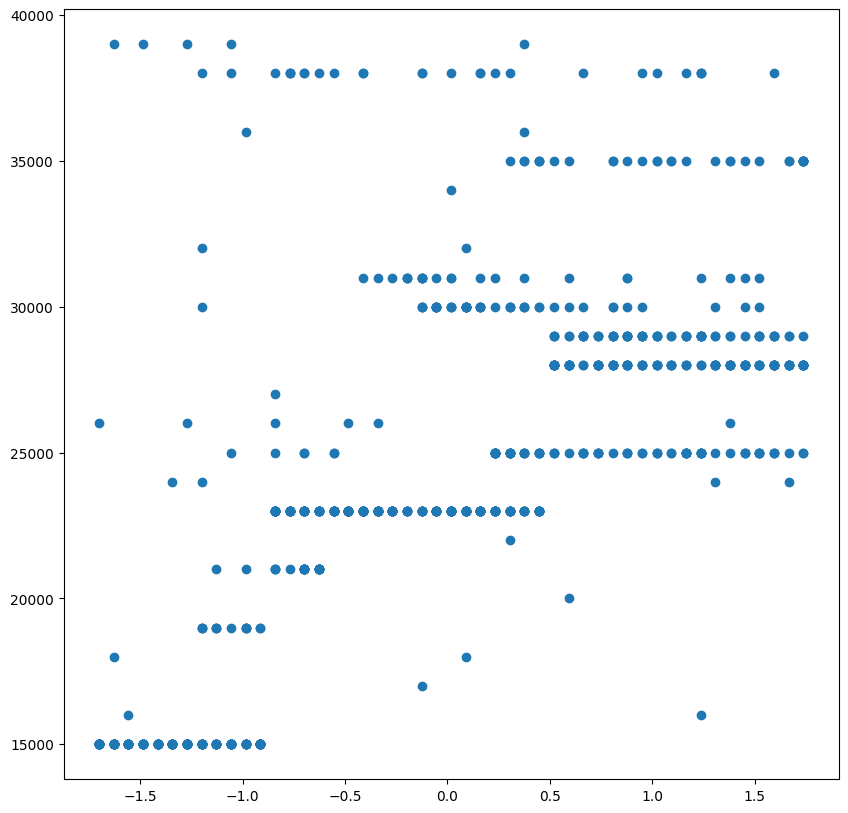

array([[1.        , 0.68992768],
       [0.68992768, 1.        ]])

In [57]:
plt.scatter(X_train[:,0],y_train)
plt.show()
np.corrcoef(X_train[:,0], y_train)

It appears that age and weight are the top two most important features in predicting the insurance premiums. First, let's try disproportionately distributing people by age between control and treatment group. Maybe assign older people to treatment group and younger people to control group. In this case, even if there is no true treatment effect, the difference in average premium would be positive because older people tend to have higher insurance premium. Can using artificial counterfactual give correct results? If there truly is a positive treatment effect, can using artificial counterfactuals estimate it correctly? 

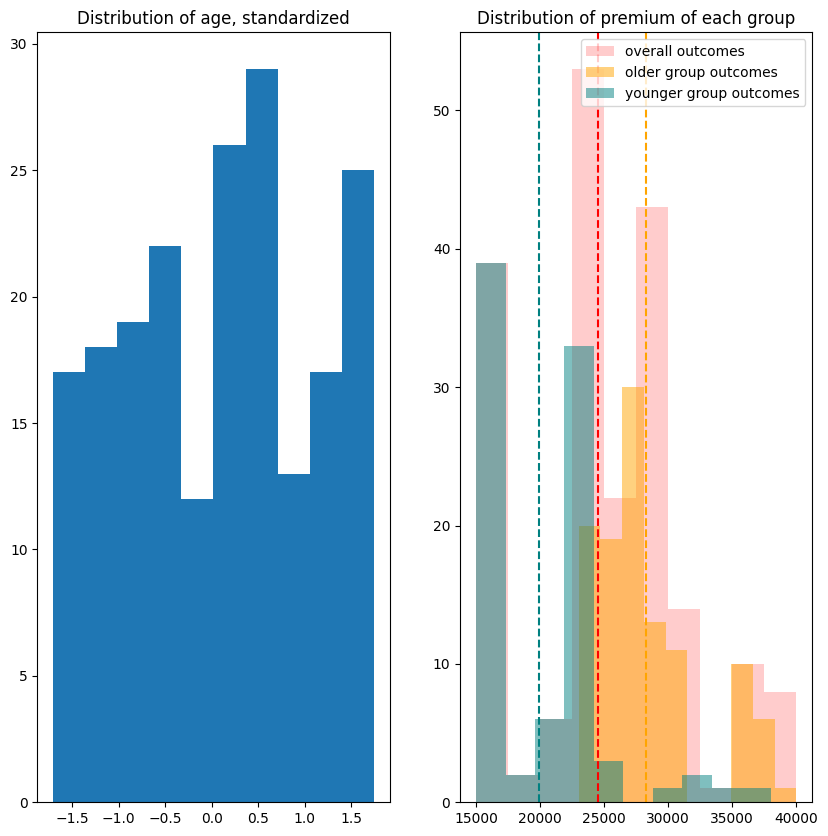

Var of older group outcomes:  18094297.520661153
Var of younger group outcomes:  25969008.264462814


In [58]:
# look at distribution of age in test data
fig, ax = plt.subplots(1,2)
ax[0].hist(X_test[:,0])
ax[0].set_title("Distribution of age, standardized")

age_mask = X_test[:,0] >= 0
ax[1].hist(y_test, alpha = 0.2, label = 'overall outcomes', color = 'red')
ax[1].hist(y_test[age_mask], alpha = 0.5, label = 'older group outcomes', color = 'orange')
ax[1].hist(y_test[np.logical_not(age_mask)], alpha = 0.5, label = 'younger group outcomes', color = 'teal')
ax[1].axvline(np.mean(y_test[age_mask]), color = 'orange', linestyle = "--")
ax[1].axvline(np.mean(y_test[np.logical_not(age_mask)]), color = 'teal', linestyle = "--")
ax[1].axvline(np.mean(y_test), color = 'red', linestyle = "--")
ax[1].set_title("Distribution of premium of each group")
ax[1].legend()
plt.show()
# looks like there are slightly more older people than younger people to begin with. 
# choose 90% of sample from older group to treatment, 10% of sample from younger group to treatment and opposite for control
print("Var of older group outcomes: ", np.var(y_test[age_mask]))
print("Var of younger group outcomes: ", np.var(y_test[np.logical_not(age_mask)]))

In [34]:
# generate multiple simulations with different group proportions
random.seed(1)
np.random.seed(1)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
old_X = X_test[age_mask,:] # features for older group
young_X = X_test[np.logical_not(age_mask),:] # features for younger group
old_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
young_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(old_y)) # number of rows from which to sample from older group
young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx]
    o_control_y = o_y[o_control_idx]
    y_treat_y = y_y[y_treat_idx]
    y_control_y = y_y[y_control_idx]
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # calculate params
    alpha1 = np.mean(treat_y - treat_preds)
    alpha0 = np.mean(control_y - control_preds)
    error1 = np.var(treat_y - treat_preds - alpha1, ddof=1)
    error0 = np.var(control_y - control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5

    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2, paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                              "pair_se_est1","pair_se_est2",
                                              "alpha1","alpha0","error1","error0"])

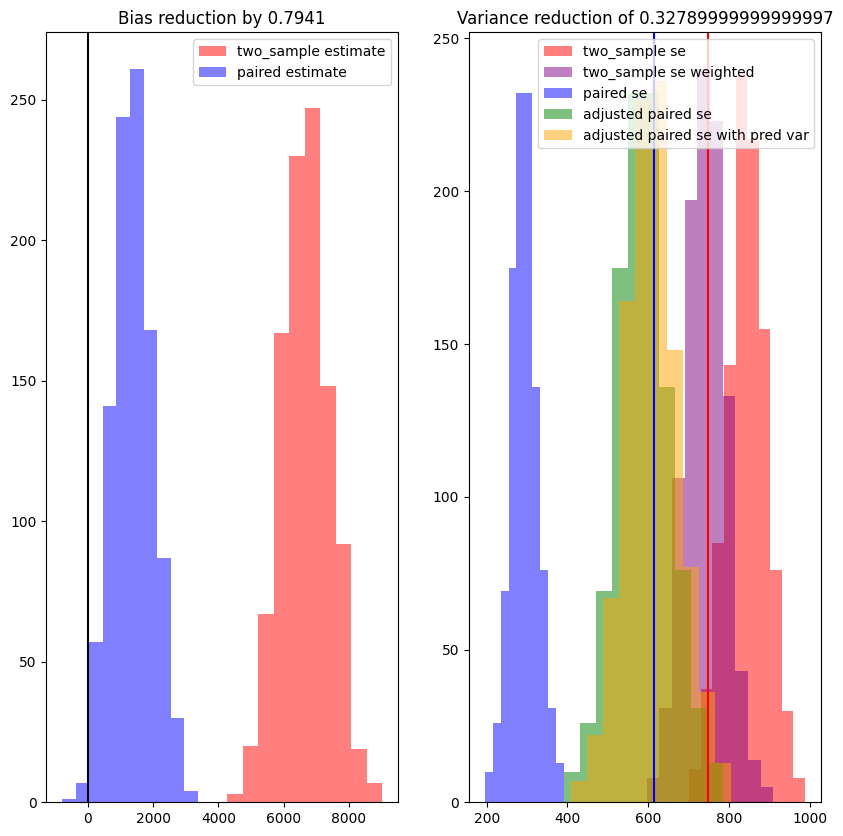

In [35]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-np.mean(sim_res['pair_est'])/np.mean(sim_res['two_est']),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')

ax[1].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var',
        color='orange')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
plt.show() 

In [36]:
# generate multiple simulations with different group proportions
# but the bias adjustment (alpha1 alpha0) is adjusting to the observed data which is disproportionately distributed.
# in this case, does not using alpha1 and alpha0 result in better bias reduction?
random.seed(1)
np.random.seed(1)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
old_X = X_test[age_mask,:] # features for older group
young_X = X_test[np.logical_not(age_mask),:] # features for younger group
old_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
young_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(old_y)) # number of rows from which to sample from older group
young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx]
    o_control_y = o_y[o_control_idx]
    y_treat_y = y_y[y_treat_idx]
    y_control_y = y_y[y_control_idx]
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # calculate params
    alpha1 = 0 #np.mean(treat_y - treat_preds)
    alpha0 = 0 #np.mean(control_y - control_preds)
    error1 = np.var(treat_y - treat_preds - alpha1, ddof=1)
    error0 = np.var(control_y - control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5

    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2, paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                              "pair_se_est1","pair_se_est2",
                                              "alpha1","alpha0","error1","error0"])

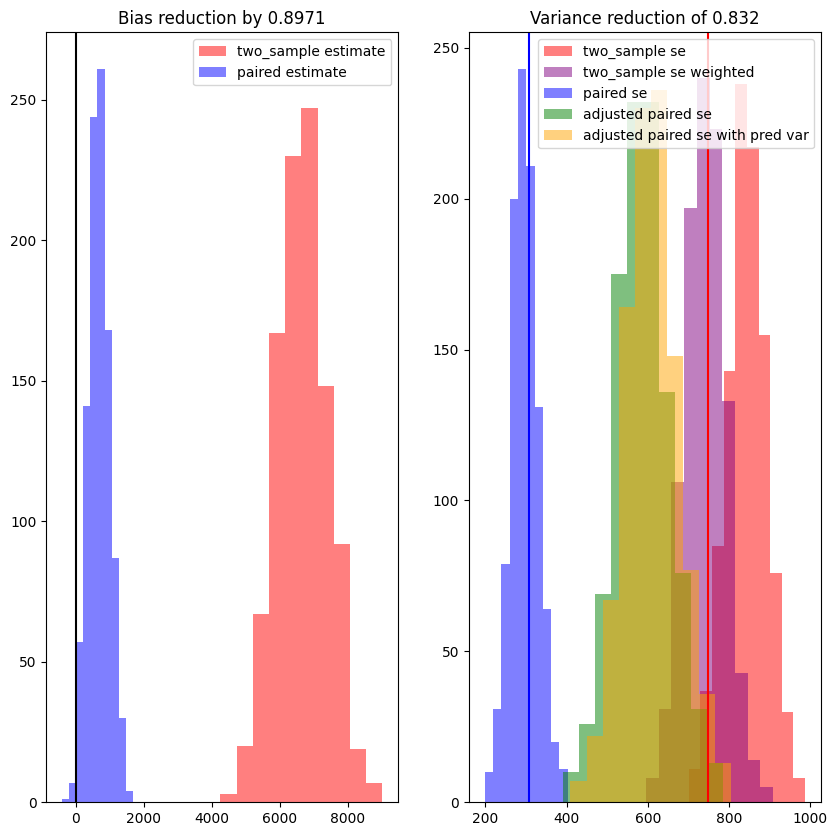

In [38]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-np.mean(sim_res['pair_est'])/np.mean(sim_res['two_est']),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')

ax[1].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var',
        color='orange')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
plt.show() 

When important covariates are disproportionately assigned to control and treatment groups, the debiasing factors (alpha1 and alpha0) seems to contribute to the bias. Also, there is reduced variance in treatment effec testimation because alpha1 and alpha0 stay constant, removing much randomness in TE estimation. This makes sense because alpha1 and alpha0 shifts predictions based on the observed values, which is already biased when important covariates are disproportionately assigned. Maybe, choose a subset of control and treat so that such subsets are balanced on the important covariates, find optimal alpha1 and alpha0, and apply this to the overall test data? 

In [66]:
# What if we calculate alpha1 and alpha0 on balanced subset, and THEN use these alphas to make adjustments to predictions? 

random.seed(134532)
np.random.seed(1543254)
te = 1000 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
old_X = X_test[age_mask,:] # features for older group
young_X = X_test[np.logical_not(age_mask),:] # features for younger group
old_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
young_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(old_y)) # number of rows from which to sample from older group
young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx].reset_index(drop=True)
    o_control_y = o_y[o_control_idx].reset_index(drop=True)
    y_treat_y = y_y[y_treat_idx].reset_index(drop=True)
    y_control_y = y_y[y_control_idx].reset_index(drop=True)
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # get a balanced subset from each group (sampled WITHOUT replacement, just getting a balanced subset of given sample)
    # in treat, there is small number of young obs compared to old obs. sample the same number of old obs as young obs from treatment group
    o_treat_bal = random.sample(range(len(o_treat_y)), k=comp_size)
    y_control_bal = random.sample(range(len(y_control_y)), k=comp_size)
    # balanced control and treat group on age
    bal_control_x = np.append(o_control_X, y_control_X[y_control_bal,], axis=0)
    bal_treat_x = np.append(o_treat_X[o_treat_bal,], y_treat_X, axis=0)
    bal_control_y = np.append(o_control_y, y_control_y[y_control_bal], axis=0)
    bal_treat_y = np.append(o_treat_y[o_treat_bal],y_treat_y, axis=0)
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # balanced sample predictions for alpha calculation
    bal_treat_preds = np.append(old_preds[o_treat_bal], young_preds[y_treat_idx], axis=0)
    bal_control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_bal], axis=0)
    # calculate params
    alpha1 = np.mean(bal_treat_y - bal_treat_preds)
    alpha0 = np.mean(bal_control_y - bal_control_preds)
    error1 = np.var(bal_treat_y - bal_treat_preds - alpha1, ddof=1)
    error0 = np.var(bal_control_y - bal_control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5
    # variance estimates with new sample size (comp_size)
    treat_pred_vars = np.append(old_pred_vars[o_treat_bal], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_bal],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est1b = (error1/(2*comp_size) + error0/(2*comp_size))**0.5
    se_est2b = (error1/(2*comp_size) + error0/(2*comp_size) 
               + treat_mean_pred_var/(2*comp_size) + control_mean_pred_var/(2*comp_size))**0.5
    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2,
                     paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0, se_est1b, se_est2b])
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                          "pair_se_est1","pair_se_est2",
                                          "alpha1","alpha0","error1","error0",
                                          "pair_se_est1b", "pair_se_est2b"])

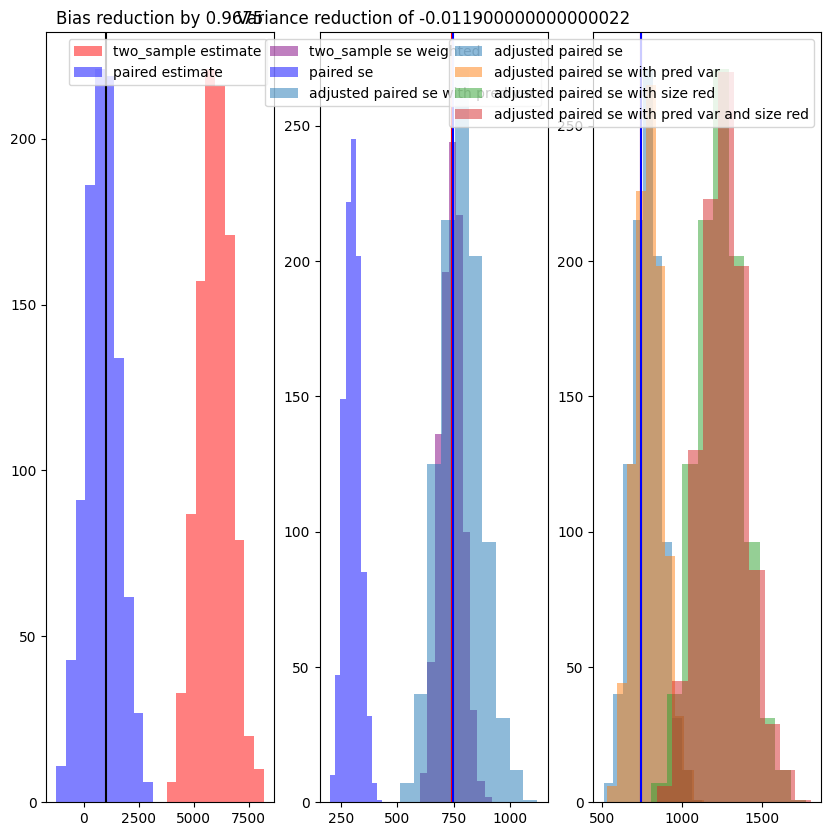

In [67]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,3)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-abs(np.mean(sim_res['pair_est'])-te)/abs(np.mean(sim_res['two_est']-te)),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

'''ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter '''
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 
'''ax[1].hist(sim_res['pair_se_est1'],
          alpha=0.5,
          label='adjusted paired se')'''
ax[1].hist(sim_res['pair_se_est1'],
          alpha=0.5,
          label='adjusted paired se with pred var')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))

ax[2].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se')

ax[2].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var')
ax[2].hist(sim_res['pair_se_est1b'],
        alpha=0.5,
        label='adjusted paired se with size red')
ax[2].hist(sim_res['pair_se_est2b'],
        alpha=0.5,
        label='adjusted paired se with pred var and size red')
ax[2].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[2].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[2].legend()
plt.show() 

Computing alpha on balanced subset gives much more bias reduction and accurately estimates treatment effect, but since alpha1 and alpha0 are computed on such small subset (10% of each sample), the variance in increased enough to the level that is essentially indifferent from two sample t-test. WHAT if balanced subset takes on the size of the larger group, sampled with replacement?

In [82]:
# What if we calculate alpha1 and alpha0 on balanced subset, and THEN use these alphas to make adjustments to predictions?
# increase balanced subset size, equal to the normal sample size, use sampling with replacement

random.seed(134532)
np.random.seed(1543254)
te = 1000 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
old_X = X_test[age_mask,:] # features for older group
young_X = X_test[np.logical_not(age_mask),:] # features for younger group
old_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
young_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(old_y)) # number of rows from which to sample from older group
young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.8) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx].reset_index(drop=True) + te
    o_control_y = o_y[o_control_idx].reset_index(drop=True)
    y_treat_y = y_y[y_treat_idx].reset_index(drop=True) + te
    y_control_y = y_y[y_control_idx].reset_index(drop=True)
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0)
    # get a balanced subset from each group (sampled WITHOUT replacement, just getting a balanced subset of given sample)
    # in treat, there is small number of young obs compared to old obs. sample the same number of old obs as young obs from treatment group
    o_control_bal = random.choices(range(len(o_control_y)), k=disprop_size)
    y_treat_bal = random.choices(range(len(y_treat_y)), k=disprop_size)
    # balanced control and treat group on age
    bal_control_x = np.append(o_control_X[o_control_bal,], y_control_X, axis=0)
    bal_treat_x = np.append(o_treat_X, y_treat_X[y_treat_bal,], axis=0)
    bal_control_y = np.append(o_control_y[o_control_bal], y_control_y, axis=0)
    bal_treat_y = np.append(o_treat_y,y_treat_y[y_treat_bal], axis=0)
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # balanced sample predictions for alpha calculation
    bal_treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_bal], axis=0)
    bal_control_preds = np.append(old_preds[o_control_bal], young_preds[y_control_idx], axis=0)
    # calculate params
    alpha1 = np.mean(bal_treat_y - bal_treat_preds)
    alpha0 = np.mean(bal_control_y - bal_control_preds)
    error1b = np.var(bal_treat_y - bal_treat_preds - alpha1, ddof=1)
    error0b = np.var(bal_control_y - bal_control_preds - alpha0, ddof=1)
    error1 = np.var(treat_y - treat_preds - alpha1, ddof=1)
    error0 = np.var(control_y - control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5
    # variance estimates with new sample size (comp_size)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_bal], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_bal],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est1b = (error1b/(2*disprop_size) + error0b/(2*disprop_size))**0.5
    se_est2b = (error1b/(2*disprop_size) + error0b/(2*disprop_size) 
               + treat_mean_pred_var/comp_size + control_mean_pred_var/comp_size)**0.5
    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2,
                     paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0, se_est1b, se_est2b])
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                          "pair_se_est1","pair_se_est2",
                                          "alpha1","alpha0","error1","error0",
                                          "pair_se_est1b", "pair_se_est2b"])

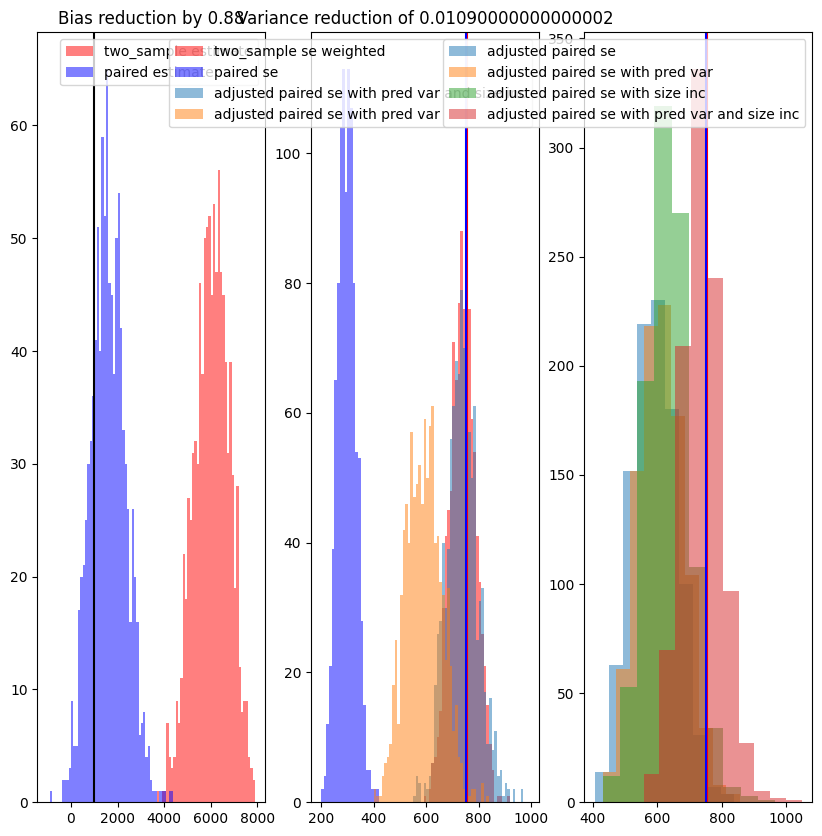

In [84]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,3)
ax[0].hist(sim_res['two_est'],  bins=range(-1000,8000,100),
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  bins=range(-1000,8000,100),
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-abs(np.mean(sim_res['pair_est'])-te)/abs(np.mean(sim_res['two_est']-te)),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

'''ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter '''
ax[1].hist(sim_res['two_se2'],  bins=range(200,1000,10),
         alpha=0.5,  
         label='two_sample se weighted', 
         color='red') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  bins=range(200,1000,10),
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 
ax[1].hist(sim_res['pair_se_est2b'],bins=range(200,1000,10),
          alpha=0.5,
          label='adjusted paired se with pred var and size inc')
ax[1].hist(sim_res['pair_se_est1'],bins=range(200,1000,10),
          alpha=0.5,
          label='adjusted paired se with pred var')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))

ax[2].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se')

ax[2].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var')
ax[2].hist(sim_res['pair_se_est1b'],
        alpha=0.5,
        label='adjusted paired se with size inc')
ax[2].hist(sim_res['pair_se_est2b'],
        alpha=0.5,
        label='adjusted paired se with pred var and size inc')
ax[2].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[2].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[2].legend()
plt.show() 

great! Things align very good. without much change to variance, we got rid of covariate related bias in treatment effect estimation. Now, let's explore what happens when varying the disproportionate size.

In [59]:
# What if we calculate alpha1 and alpha0 on balanced subset, and THEN use these alphas to make adjustments to predictions?
# increase balanced subset size, equal to the normal sample size, use sampling with replacement
# simulate across different disproportion rates
random.seed(1)
np.random.seed(1)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
o_X = X_test[age_mask,:] # features for older group
y_X = X_test[np.logical_not(age_mask),:] # features for younger group
o_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
y_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
#o_range = range(0, len(old_y)) # number of rows from which to sample from older group
#young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
prop = np.arange(0,1.1,0.1)
sim_res_dic = {}
for j in range(len(prop)):
    temp_res = []
    disprop_size = int(sample_size * prop[j]) # number of samples to be taken from older group to treatment
    comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
    for i in range(num_preds):
        # sample disprop from old for treat and from young for control
        # sample comp from old for control and from young for treat
        o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
        o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
        y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
        y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
        # extract rows corresponding to each group/age-split
        o_treat_X = o_X[o_treat_idx,]
        o_control_X = o_X[o_control_idx,]
        y_treat_X = y_X[y_treat_idx,]
        y_control_X = y_X[y_control_idx,]
        o_treat_y = o_y[o_treat_idx].reset_index(drop=True) + te
        o_control_y = o_y[o_control_idx].reset_index(drop=True)
        y_treat_y = y_y[y_treat_idx].reset_index(drop=True) + te
        y_control_y = y_y[y_control_idx].reset_index(drop=True)
        # group them together to one control and treatment groups
        control_X = np.append(o_control_X, y_control_X, axis=0)
        treat_X = np.append(o_treat_X, y_treat_X,axis=0)
        control_y = np.append(o_control_y,y_control_y,axis=0)
        treat_y = np.append(o_treat_y,y_treat_y,axis=0)
        # what if just resample with size = sample size from each group
        # if no old in treat or no old in control, need to modify so that returns empty index
        if len(o_control_y) == 0 or len(y_treat_y) == 0:
            o_control_bal = []
            y_treat_bal = []
            o_treat_bal = random.choices(range(len(o_treat_y)), k=2*sample_size)
            y_control_bal = random.choices(range(len(y_control_y)), k=2*sample_size)
        elif len(o_treat_y) == 0 or len(y_control_y) == 0:
            o_treat_bal = []
            y_control_bal = []
            o_control_bal = random.choices(range(len(o_control_y)), k=2*sample_size)
            y_treat_bal = random.choices(range(len(y_treat_y)), k=2*sample_size)
        else:
            o_control_bal = random.choices(range(len(o_control_y)), k=sample_size)
            y_treat_bal = random.choices(range(len(y_treat_y)), k=sample_size)
            o_treat_bal = random.choices(range(len(o_treat_y)), k=sample_size)
            y_control_bal = random.choices(range(len(y_control_y)), k=sample_size)
        # balanced control and treat group on age
        bal_control_x = np.append(o_control_X[o_control_bal,], y_control_X[y_control_bal,], axis=0)
        bal_treat_x = np.append(o_treat_X[o_treat_bal,], y_treat_X[y_treat_bal,], axis=0)
        bal_control_y = np.append(o_control_y[o_control_bal], y_control_y[y_control_bal], axis=0)
        bal_treat_y = np.append(o_treat_y[o_treat_bal],y_treat_y[y_treat_bal], axis=0)
        # select one of the predictions
        predictions = pred_res[i]
        old_preds = predictions[age_mask]
        young_preds = predictions[np.logical_not(age_mask)]
        treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
        control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
        # balanced sample predictions for alpha calculation
        bal_treat_preds = np.append(old_preds[o_treat_bal], young_preds[y_treat_bal], axis=0)
        bal_control_preds = np.append(old_preds[o_control_bal], young_preds[y_control_bal], axis=0)
        # calculate params
        alpha1 = np.mean(bal_treat_y - bal_treat_preds)
        alpha0 = np.mean(bal_control_y - bal_control_preds)
        error1b = np.var(bal_treat_y - bal_treat_preds - alpha1, ddof=1)
        error0b = np.var(bal_control_y - bal_control_preds - alpha0, ddof=1)
        error1 = np.nan_to_num(np.var(treat_y - treat_preds - alpha1, ddof=1))
        error0 = np.nan_to_num(np.var(control_y - control_preds - alpha0, ddof=1))
        # generate artificial counterfactuals
        synt_treat_obs = control_preds + alpha1
        synt_control_obs = treat_preds + alpha0
        # variance estimate without prediction variance
        se_est1 = (error1/treat_size + error0/control_size)**0.5
        # variance estimate with prediction variance taken into account
        old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
        young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
        treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
        control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
        control_mean_pred_var = np.mean(control_pred_vars)
        treat_mean_pred_var = np.mean(treat_pred_vars)
        se_est2 = (error1/treat_size + error0/control_size 
                   + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
        # combine obs for paired test
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        # two sample test results
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        #inaccurate se estimate, must weight it by group
        two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
        treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
        control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
        two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
        # paired test results
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5
        # variance estimates with new sample size (comp_size)
        treat_pred_vars = np.append(old_pred_vars[o_treat_bal], young_pred_vars[y_treat_bal], axis=0)
        control_pred_vars = np.append(old_pred_vars[o_control_bal],young_pred_vars[y_control_bal],axis=0)
        control_mean_pred_var = np.mean(control_pred_vars)
        treat_mean_pred_var = np.mean(treat_pred_vars)
        se_est1b = (error1b/(2*sample_size) + error0b/(2*sample_size))**0.5
        se_est2b = (error1b/(2*sample_size) + error0b/(2*sample_size) 
                   + treat_mean_pred_var/sample_size + control_mean_pred_var/sample_size)**0.5
        # store results
        temp_res.append([two_sample_te, two_sample_se, two_sample_se2,
                         paired_te, paired_se, se_est1, se_est2,
                         alpha1, alpha0, error1, error0, se_est1b, se_est2b])
    sim_res_dic[prop[j]] = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                              "pair_se_est1","pair_se_est2",
                                              "alpha1","alpha0","error1","error0",
                                              "pair_se_est1b", "pair_se_est2b"])

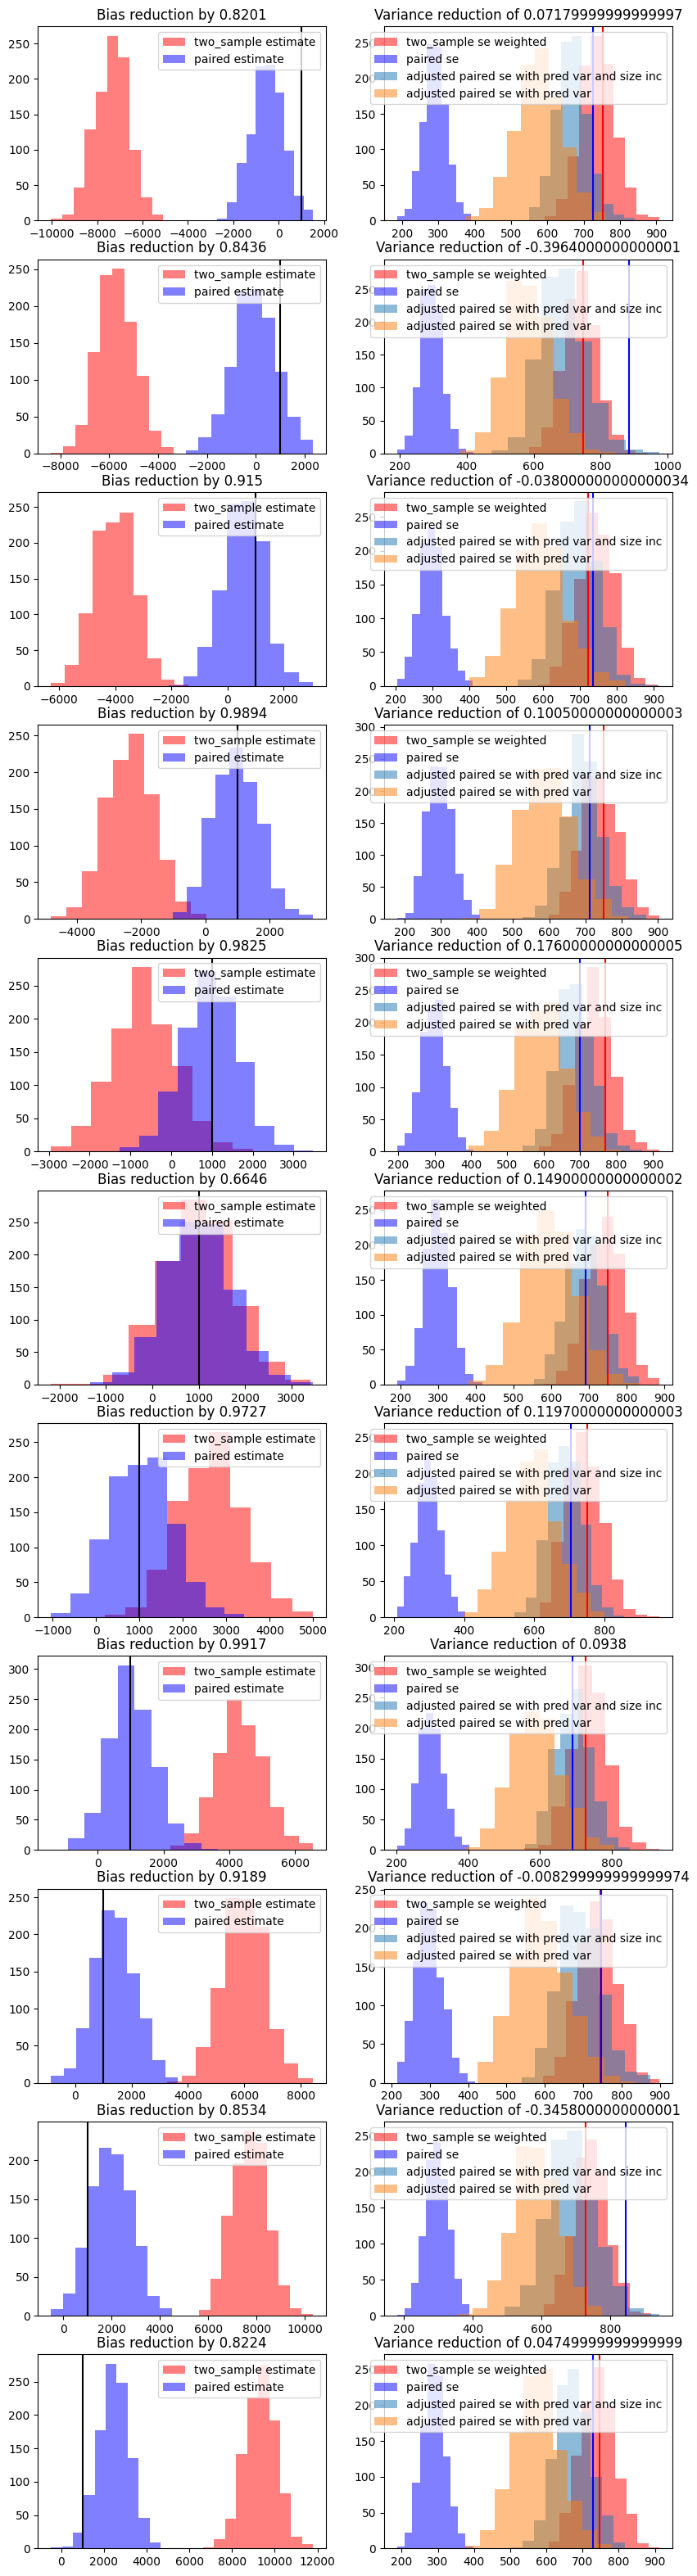

In [97]:
plt.rcParams['figure.figsize'] = [10, 40]
fig, ax = plt.subplots(len(prop),2)
for j in range(len(prop)):
    sim_res = sim_res_dic[prop[j]]
    ax[j,0].hist(sim_res['two_est'],  
             alpha=0.5,  
             label='two_sample estimate', 
             color='red') # customized color parameter 

    ax[j,0].hist(sim_res['pair_est'],  
             alpha=0.5,  
             label='paired estimate', 
             color='blue') # customized color parameter 
    ax[j,0].axvline(te, color='black')
    ax[j,0].legend() 
    bias_reduction_factor = round(1-abs(np.mean(sim_res['pair_est'])-te)/abs(np.mean(sim_res['two_est']-te)),4)
    ax[j,0].set_title("Bias reduction by " + str(bias_reduction_factor))

    '''ax[1].hist(sim_res['two_se'],  
             alpha=0.5,  
             label='two_sample se', 
             color='red') # customized color parameter '''
    ax[j,1].hist(sim_res['two_se2'],  
             alpha=0.5,  
             label='two_sample se weighted', 
             color='red') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se'],  
             alpha=0.5,  
             label='paired se', 
             color='blue') # customized color parameter 
    ax[j,1].hist(sim_res['pair_se_est2b'],
              alpha=0.5,
              label='adjusted paired se with pred var and size inc')
    ax[j,1].hist(sim_res['pair_se_est1'],
              alpha=0.5,
              label='adjusted paired se with pred var')

    ax[j,1].legend() 
    ax[j,1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
    ax[j,1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
    ax[j,1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                         /np.var(sim_res["two_est"], ddof=1),4)))
plt.show()

In [89]:
# find how to properly calculate paired se when we know the weight of old and young in control and treatment group. 
# it is displaying the same shift as seen in two sample when weight of old and young was not taken into account
# for its se estimation.

Series([], Name: PremiumPrice, dtype: int64)